<a href="https://colab.research.google.com/github/xy2119/SO3_Invariant_ProteinMPNN/blob/main/notebooks/mpnn_wAF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotation Invariant ProteinMPNN w/AF2
This notebook is intended as a quick demo, more features to come!

Examples: 


0.   pdb: `1O91`, homomer: `True`, designed_chain: `A`
1.   pdb: `6MRR`, homomer: `False`, designed_chain: `A`
2.   pdb: `1X2I`, homomer: `True`, designed_chain: `A,B` 
     (for correct symmetric tying lenghts of homomer chains should be the same)

In [ ]:
#@title Setup ProteinMPNN
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json, time, os, sys, glob, re
from google.colab import files
import numpy as np
if not os.path.isdir("ProteinMPNN"):
  os.system("git clone -q https://github.com/xy2119/SO3_Invariant_ProteinMPNN.git")

if "SO3_Invariant_ProteinMPNN" not in sys.path:
  sys.path.append('/content/SO3_Invariant_ProteinMPNN')

import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
!pip install -U kaleido
import plotly.express as px
import plotly.io as pio
import shutil
import warnings
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB,parse_fasta
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, ProteinMPNN
def make_tied_positions_for_homomers(pdb_dict_list):
    my_dict = {}
    for result in pdb_dict_list:
        all_chain_list = sorted([item[-1:] for item in list(result) if item[:9]=='seq_chain']) #A, B, C, ...
        tied_positions_list = []
        chain_length = len(result[f"seq_chain_{all_chain_list[0]}"])
        for i in range(1,chain_length+1):
            temp_dict = {}
            for j, chain in enumerate(all_chain_list):
                temp_dict[chain] = [i] #needs to be a list
            tied_positions_list.append(temp_dict)
        my_dict[result['name']] = tied_positions_list
    return my_dict

#########################
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  else:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.9 MB/s eta 0:00:00


In [ ]:
#@title Setup AlphaFold

# import libraries
from IPython.utils import io
import os,sys,re

if "af_backprop" not in sys.path:
  import tensorflow as tf
  import jax
  import jax.numpy as jnp
  import numpy as np
  import matplotlib
  from matplotlib import animation
  import matplotlib.pyplot as plt
  from IPython.display import HTML
  import tqdm.notebook
  TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

  with io.capture_output() as captured:
    # install ALPHAFOLD
    if not os.path.isdir("af_backprop"):
      %shell git clone https://github.com/sokrypton/af_backprop.git
      %shell pip -q install biopython dm-haiku ml-collections py3Dmol
      %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
    if not os.path.isdir("params"):
      %shell mkdir params
      %shell curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

  if not os.path.exists("MMalign"):
    # install MMalign
    os.system("wget -qnc https://zhanggroup.org/MM-align/bin/module/MMalign.cpp")
    os.system("g++ -static -O3 -ffast-math -o MMalign MMalign.cpp")

  def mmalign(pdb_a,pdb_b):
    # pass to MMalign
    output = os.popen(f'./MMalign {pdb_a} {pdb_b}')
    # parse outputs
    parse_float = lambda x: float(x.split("=")[1].split()[0])
    tms = []
    for line in output:
      line = line.rstrip()
      if line.startswith("TM-score"): tms.append(parse_float(line))
    return tms

  # configure which device to use
  try:
    # check if TPU is available
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print('Running on TPU')
    DEVICE = "tpu"
  except:
    if jax.local_devices()[0].platform == 'cpu':
      print("WARNING: no GPU detected, will be using CPU")
      DEVICE = "cpu"
    else:
      print('Running on GPU')
      DEVICE = "gpu"
      # disable GPU on tensorflow
      tf.config.set_visible_devices([], 'GPU')

  # import libraries
  sys.path.append('af_backprop')
  from utils import update_seq, update_aatype, get_plddt, get_pae
  import colabfold as cf
  from alphafold.common import protein as alphafold_protein
  from alphafold.data import pipeline
  from alphafold.model import data, config
  from alphafold.common import residue_constants
  from alphafold.model import model as alphafold_model

# custom functions
def clear_mem():
  backend = jax.lib.xla_bridge.get_backend()
  for buf in backend.live_buffers(): buf.delete()

def setup_model(max_len):
  clear_mem()

  # setup model
  cfg = config.model_config("model_3_ptm")
  cfg.model.num_recycle = 0
  cfg.data.common.num_recycle = 0
  cfg.data.eval.max_msa_clusters = 1
  cfg.data.common.max_extra_msa = 1
  cfg.data.eval.masked_msa_replace_fraction = 0
  cfg.model.global_config.subbatch_size = None

  # get params
  model_param = data.get_model_haiku_params(model_name="model_3_ptm", data_dir=".")
  model_runner = alphafold_model.RunModel(cfg, model_param, is_training=False, recycle_mode="none")

  model_params = []
  for k in [1,2,3,4,5]:
    if k == 3:
      model_params.append(model_param)
    else:
      params = data.get_model_haiku_params(model_name=f"model_{k}_ptm", data_dir=".")
      model_params.append({k: params[k] for k in model_runner.params.keys()})

  seq = "A" * max_len
  length = len(seq)
  feature_dict = {
      **pipeline.make_sequence_features(sequence=seq, description="none", num_res=length),
      **pipeline.make_msa_features(msas=[[seq]], deletion_matrices=[[[0]*length]])
  }
  inputs = model_runner.process_features(feature_dict,random_seed=0)

  def runner(I, params):
    # update sequence
    inputs = I["inputs"]
    inputs.update(I["prev"])

    seq = jax.nn.one_hot(I["seq"],20)
    update_seq(seq, inputs)
    update_aatype(inputs["target_feat"][...,1:], inputs)

    # mask prediction
    mask = jnp.arange(inputs["residue_index"].shape[0]) < I["length"]
    inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
    inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
    inputs["residue_index"] = jnp.where(mask, inputs["residue_index"], 0)

    # get prediction
    key = jax.random.PRNGKey(0)
    outputs = model_runner.apply(params, key, inputs)

    prev = {"init_msa_first_row":outputs['representations']['msa_first_row'][None],
            "init_pair":outputs['representations']['pair'][None],
            "init_pos":outputs['structure_module']['final_atom_positions'][None]}
    
    aux = {"final_atom_positions":outputs["structure_module"]["final_atom_positions"],
           "final_atom_mask":outputs["structure_module"]["final_atom_mask"],
           "plddt":get_plddt(outputs),"pae":get_pae(outputs),
           "length":I["length"], "seq":I["seq"], "prev":prev,
           "residue_idx":inputs["residue_index"][0]}
    return aux

  return jax.jit(runner), model_params, {"inputs":inputs, "length":max_length}

def save_pdb(outs, filename, Ls=None):
  '''save pdb coordinates'''
  p = {"residue_index":outs["residue_idx"] + 1,
       "aatype":outs["seq"],
       "atom_positions":outs["final_atom_positions"],
       "atom_mask":outs["final_atom_mask"],
       "plddt":outs["plddt"]}
  p = jax.tree_map(lambda x:x[:outs["length"]], p)
  b_factors = 100 * p.pop("plddt")[:,None] * p["atom_mask"]
  p = alphafold_protein.Protein(**p,b_factors=b_factors)
  pdb_lines = alphafold_protein.to_pdb(p)
  with open(filename, 'w') as f:
    f.write(pdb_lines)
  if Ls is not None:
    pdb_lines = cf.read_pdb_renum(filename, Ls)
    with open(filename, 'w') as f:
      f.write(pdb_lines)
 


/usr/local/lib/python3.8/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


In [ ]:
# helper funciton
import os

def plot_conditional_probs_heatmap(all_log_probs_concat, alphabet, path):
    fig = px.imshow(np.exp(all_log_probs_concat).mean(0).T,
                    labels=dict(x="positions", y="amino acids", color="probability"),
                    y=list(alphabet),
                    template="simple_white")
    fig.update_xaxes(side="bottom")
    fig.update_layout(title=dict(text="Mean Probability of Amino Acids by Position (Conditional Probabilities)", y=0.95),
                      xaxis_title="positions")
    pio.write_html(fig, file=os.path.join(path, "log_probs.html"), auto_open=False)
    fig.show()

def plot_sampled_probs_heatmap(all_probs_concat, alphabet, path):
    fig = px.imshow(all_probs_concat.mean(0).T,
                    labels=dict(x="positions", y="amino acids", color="probability"),
                    y=list(alphabet),
                    template="simple_white")
    fig.update_xaxes(side="bottom")
    fig.update_layout(title=dict(text="Mean Probability of Amino Acids by Position (Sampled)", y=0.95),
                      xaxis_title="positions")
    pio.write_html(fig, file=os.path.join(path, "probs.html"), auto_open=False)
    fig.show()
 

In [ ]:

pdb=pd.read_csv("/content/SO3_Invariant_ProteinMPNN/dataset/test_mono.csv",index_col=0)
pdb=','.join(pdb["PROTEIN"])

In [ ]:
#@title # ProteinMPNN with AlphaFold 2 (Ca_80epoch)

#@markdown ## Input Options
#pdb='1O91, 1X2I' #@param {type:"string"}
#@markdown - pdb code (leave blank to get an upload prompt)
pdb = pdb.replace(" ","").split(",")
pdb_list = [pro.strip() for pro in pdb]

homomer = False #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}
#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

omit_AAs='X'#@param {type:"string"}
#@markdown - Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))



#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown ## Design Options
device = torch.device("cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "Ca_48_020_80e" #@param ["benchmark_Ca_48_002", "benchmark_Ca_48_010", "benchmark_Ca_48_020","Ca_48_020_80e","Ca_48_020_150e","Ca_48_020_200e","Ca_SH_48_020_80e","Ca_SH_48_020_150e","Ca_SH_48_020_200e"]

num_seqs = 4 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

save_score=1                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=1                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
unconditional_probs_only=0

batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  #@param {type:"integer"}
                                  #@markdown - Max sequence length
backbone_noise=0.00               #@param ["0.00","0.10","0.20","0.25","0.30"]  
                                  #@markdown - Standard deviation of Gaussian noise to add to backbone atoms
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
folder_for_outputs = out_folder
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
path_to_fasta=''
# Build paths for experiment
base_folder = folder_for_outputs
if base_folder[-1] != '/':
    base_folder = base_folder + '/'

if not os.path.exists(base_folder):
    os.makedirs(base_folder)

if not os.path.exists(base_folder + model_name):
    os.makedirs(base_folder + model_name)

if not os.path.exists(base_folder + model_name + '/seqs'):
    os.makedirs(base_folder + model_name + '/seqs')

if save_score:
    if not os.path.exists(base_folder + model_name + '/scores'):
        os.makedirs(base_folder + model_name + '/scores')

if score_only:
    if not os.path.exists(base_folder + model_name + '/score_only'):
        os.makedirs(base_folder + model_name + '/score_only')

if conditional_probs_only:
    if not os.path.exists(base_folder + model_name + '/conditional_probs_only'):
        os.makedirs(base_folder + model_name + '/conditional_probs_only')

if unconditional_probs_only:
    if not os.path.exists(base_folder + model_name + '/unconditional_probs_only'):
        os.makedirs(base_folder + model_name + '/unconditional_probs_only')

if save_probs:
    if not os.path.exists(base_folder + model_name + '/probs'):
        os.makedirs(base_folder + model_name + '/probs') 

if not os.path.exists(base_folder + model_name + '/output'):
    os.makedirs(base_folder + model_name + '/output')

if not os.path.exists(base_folder + 'results'):
    os.makedirs(base_folder + 'results')


pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True



if model_name[:5] == 'Ca_SH':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_SH_48_020'  
  ca_only=True
  rsh_expand=True
elif model_name[:2] == 'Ca':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_48_020'  
  ca_only=True
  rsh_expand=False
elif model_name[:12] == 'benchmark_Ca':
  model_name='v_'+model_name[-6:]
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  ca_only=True
  rsh_expand=False
elif model_name[:17] == 'benchmark_vanilla':
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  rsh_expand=False
else:
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  #rsh_expand=True
print('Ca level:',ca_only,'SH Expansion:',rsh_expand)

hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'], ca_only=ca_only,rsh_expand=rsh_expand)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]
#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.




#@markdown ### Run AlphaFold
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = num_seqs 
outs = []
positions = []
plddts = []
paes = []
LS = []

##############################################################

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
alphabet_dict = dict(zip(alphabet, range(21)))   
omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)
suppress_print = 1 
print_all = suppress_print 

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
info_list=[]
for pdb in pdb_list:
  pdb_path = get_pdb(pdb)
  pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
  dataset_test = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)
  
  chain_id_dict = {}
  chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

  print(chain_id_dict)
  for chain in chain_list:
    l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
    print(f"Length of chain {chain} is {l}")

  if homomer:
    tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
  else:
    tied_positions_dict = None

  #################################################################
  # Timing
  start_time = time.time()
  sequences = []

  with torch.no_grad():
    print('Generating sequences...')
    for ix, protein in enumerate(dataset_test):
      score_list = []
      global_score_list = []
      all_probs_list = []
      all_log_probs_list = []
      S_sample_list = []
      batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
      X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
      pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
      ssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
      name_ = batch_clones[0]['name']

      if score_only:
          loop_c = 0 
          if path_to_fasta:
              fasta_names, fasta_seqs = parse_fasta(path_to_fasta, omit=["/"])
              loop_c = len(fasta_seqs)
          for fc in range(1+loop_c):
              if fc == 0:
                  structure_sequence_score_file = base_folder + '/score_only/' + batch_clones[0]['name'] + f'_pdb'
              else:
                  structure_sequence_score_file = base_folder + '/score_only/' + batch_clones[0]['name'] + f'_fasta_{fc}'              
              
              native_score_list = []
              global_native_score_list = []
              if fc > 0:
                  input_seq_length = len(fasta_seqs[fc-1])
                  S_input = torch.tensor([alphabet_dict[AA] for AA in fasta_seqs[fc-1]], device=device)[None,:].repeat(X.shape[0], 1)
                  S[:,:input_seq_length] = S_input #assumes that S and S_input are alphabetically sorted for masked_chains
              for j in range(NUM_BATCHES):
                  randn_1 = torch.randn(chain_M.shape, device=X.device)
                  log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
                  mask_for_loss = mask*chain_M*chain_M_pos
                  scores = _scores(S, log_probs, mask_for_loss)
                  native_score = scores.cpu().data.numpy()
                  native_score_list.append(native_score)
                  global_scores = _scores(S, log_probs, mask)
                  global_native_score = global_scores.cpu().data.numpy()
                  global_native_score_list.append(global_native_score)
                  
              native_score = np.concatenate(native_score_list, 0)
              global_native_score = np.concatenate(global_native_score_list, 0)
              ns_mean = native_score.mean()
              ns_mean_print = np.format_float_positional(np.float32(ns_mean), unique=False, precision=4)
              ns_std = native_score.std()
              ns_std_print = np.format_float_positional(np.float32(ns_std), unique=False, precision=4)

              global_ns_mean = global_native_score.mean()
              global_ns_mean_print = np.format_float_positional(np.float32(global_ns_mean), unique=False, precision=4)
              global_ns_std = global_native_score.std()
              global_ns_std_print = np.format_float_positional(np.float32(global_ns_std), unique=False, precision=4)

              ns_sample_size = native_score.shape[0]
              seq_str = _S_to_seq(S[0,], chain_M[0,])
              #np.savez(structure_sequence_score_file, score=native_score, global_score=global_native_score, S=S[0,].cpu().numpy(), seq_str=seq_str)
              if print_all:
                  if fc == 0:
                      print(f'Score for {name_} from PDB, mean: {ns_mean_print}, std: {ns_std_print}, sample size: {ns_sample_size},  global score, mean: {global_ns_mean_print}, std: {global_ns_std_print}, sample size: {ns_sample_size}')
                  else:
                      print(f'Score for {name_}_{fc} from FASTA, mean: {ns_mean_print}, std: {ns_std_print}, sample size: {ns_sample_size},  global score, mean: {global_ns_mean_print}, std: {global_ns_std_print}, sample size: {ns_sample_size}')
            
      elif conditional_probs_only:
          if print_all:
              print(f'Calculating conditional probabilities for {name_}')
          conditional_probs_only_file = base_folder + '/conditional_probs_only/' + batch_clones[0]['name']
          log_conditional_probs_list = []
          for j in range(NUM_BATCHES):
              randn_1 = torch.randn(chain_M.shape, device=X.device)
              log_conditional_probs = model.conditional_probs(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1, conditional_probs_only_backbone)
              log_conditional_probs_list.append(log_conditional_probs.cpu().numpy())
          concat_log_p = np.concatenate(log_conditional_probs_list, 0) #[B, L, 21]
          mask_out = (chain_M*chain_M_pos*mask)[0,].cpu().numpy()
          np.savez(conditional_probs_only_file, log_p=concat_log_p, S=S[0,].cpu().numpy(), mask=mask[0,].cpu().numpy(), design_mask=mask_out)
      elif unconditional_probs_only:
          if print_all:
              print(f'Calculating sequence unconditional probabilities for {name_}')
          unconditional_probs_only_file = base_folder + '/unconditional_probs_only/' + batch_clones[0]['name']
          log_unconditional_probs_list = []
          for j in range(NUM_BATCHES):
              log_unconditional_probs = model.unconditional_probs(X, mask, residue_idx, chain_encoding_all)
              log_unconditional_probs_list.append(log_unconditional_probs.cpu().numpy())
          concat_log_p = np.concatenate(log_unconditional_probs_list, 0) #[B, L, 21]
          mask_out = (chain_M*chain_M_pos*mask)[0,].cpu().numpy()
          np.savez(unconditional_probs_only_file, log_p=concat_log_p, S=S[0,].cpu().numpy(), mask=mask[0,].cpu().numpy(), design_mask=mask_out)
 
      else:
          randn_1 = torch.randn(chain_M.shape, device=X.device)
          log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
          mask_for_loss = mask*chain_M*chain_M_pos
          scores = _scores(S, log_probs, mask_for_loss) #score only the redesigned part
          native_score = scores.cpu().data.numpy()
          global_scores = _scores(S, log_probs, mask) #score the whole structure-sequence
          global_native_score = global_scores.cpu().data.numpy()
          
          log_conditional_probs_list = []
          log_unconditional_probs_list = []
          # Generate some sequences
          base_path= base_folder + model_name

          if not os.path.exists(base_path + f"/output/{name_}"):
              os.makedirs(base_path + f"/output/{name_}")
          if not os.path.exists(base_path + f"/seqs/{name_}"):
              os.makedirs(base_path + f"/seqs/{name_}")
          if not os.path.exists(base_path + f"/scores/{name_}"):
              os.makedirs(base_path + f"/scores/{name_}")
          if not os.path.exists(base_path + f"/probs/{name_}"):
              os.makedirs(base_path + f"/probs/{name_}")
              
          ali_file = base_path + f'/scores/{name_}/' + name_ + '.fa'
          score_file = base_path + f'/scores/{name_}/' + name_ + '.npz'
          probs_file = base_path + f'/probs/{name_}/' + name_ + '.npz'
          if print_all:
              print(f'Generating sequences for: {name_}')
          t0 = time.time()
          with open(ali_file, 'w') as f:
              for temp in temperatures:
                  for j in range(NUM_BATCHES): 

                      native_score_list = []
                      global_native_score_list = [] 
                      randn_2 = torch.randn(chain_M.shape, device=X.device)
                      if tied_positions_dict == None:
                          sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                          S_sample = sample_dict["S"] 
                      else:
                          sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
                          S_sample = sample_dict["S"]
                      
                      log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
                      mask_for_loss = mask*chain_M*chain_M_pos
                      scores = _scores(S_sample, log_probs, mask_for_loss)
                      scores = scores.cpu().data.numpy()
                      native_score_list.append(scores)
                      global_scores = _scores(S_sample, log_probs, mask)
                      global_native_score = global_scores.cpu().data.numpy()
                      global_native_score_list.append(global_native_score)

                      all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
                      all_log_probs_list.append(log_probs.cpu().data.numpy())
                      S_sample_list.append(S_sample.cpu().data.numpy())
                              
                      for b_ix in range(BATCH_COPIES):
                          masked_chain_length_list = masked_chain_length_list_list[b_ix]
                          masked_list = masked_list_list[b_ix]
                          seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                          seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                          
                          score = scores[b_ix]
                          score_list.append(score)
                          global_score = global_scores[b_ix]
                          global_score_list.append(global_score)
                          native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                          if b_ix == 0 and j==0 and temp==temperatures[0]:
                              start = 0
                              end = 0
                              list_of_AAs = []
                              for mask_l in masked_chain_length_list:
                                  end += mask_l
                                  list_of_AAs.append(native_seq[start:end])
                                  start = end
                              native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                              l0 = 0
                              for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                                  l0 += mc_length
                                  native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                                  l0 += 1
                              sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                              print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                              sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                              print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                              native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                              global_native_score_print = np.format_float_positional(np.float32(global_native_score.mean()), unique=False, precision=4)
                              line = '>{}, score={}, global_score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.\
                              format(name_, 
                                    native_score_print, 
                                    global_native_score_print,
                                    print_visible_chains, 
                                    print_masked_chains, 
                                    model_name, 
                                    native_seq)
                              print(line.rstrip())
                              
                            
                          start = 0
                          end = 0
                          list_of_AAs = []
                          for mask_l in masked_chain_length_list:
                              end += mask_l
                              list_of_AAs.append(seq[start:end])
                              start = end

                          seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                          l0 = 0
                          for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                              l0 += mc_length
                              seq = seq[:l0] + '/' + seq[l0:]
                              l0 += 1
                          score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                          global_score_print = np.format_float_positional(np.float32(global_score), unique=False, precision=4)
                          seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                          sample_number=j*BATCH_COPIES+b_ix+1
                          line = '\n>T={}, sample={}, score={}, global_score={}, seq_recovery={}\n{}\n'.\
                          format(temp,
                                j,
                                score_print,
                                global_score_print,
                                seq_rec_print,
                                seq)
                          sequences.append(seq)
                          print(line.rstrip())

          ########################### AF2 Start #####################################
                          with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models, bar_format=TQDM_BAR_FORMAT) as pbar:
                          
                            print(f"seq_num model_num   avg_pLDDT avg_pAE TMscore")
                            s=j
                            ori_sequence=seq
                            Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
                            LS.append(Ls)
                            sequence = re.sub("[^A-Z]","",ori_sequence)
                            length = len(sequence)

                            # avoid recompiling if length within 25
                            if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
                              max_len = length + 25
                              runner, params, I = setup_model(max_len)

                            outs.append([])
                            positions.append([])
                            plddts.append([])
                            paes.append([])

                            r = -1
                            # pad sequence to max length
                            seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
                            seq = np.pad(seq,[0,max_len-length],constant_values=-1)
                            I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
                            I.update({"seq":seq, "length":length})
                            
                            # for each model
                            for n in range(num_models):
                              # restart recycle
                              I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                                          'init_pair': np.zeros([1, max_len, max_len, 128]),
                                          'init_pos': np.zeros([1, max_len, 37, 3])}
                              for r in range(num_recycles + 1):
                                O = runner(I, params[n])
                                O = jax.tree_map(lambda x:np.asarray(x), O)
                                I["prev"] = O["prev"]
                                pbar.update(1)
                              
                              positions[-1].append(O["final_atom_positions"][:length])
                              plddts[-1].append(O["plddt"][:length])
                              paes[-1].append(O["pae"][:length,:length])
                              outs[-1].append(O)
                              save_pdb(outs[-1][-1], base_path + f"/output/{name_}/out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
                              tmscores = mmalign(pdb_path, base_path + f"/output/{name_}/out_seq_{s}_model_{n}.pdb")
                              print(f"   {s}  \t{n}\t\t{plddts[-1][-1].mean():.3} \t{paes[-1][-1].mean():.3} \t{tmscores[-1]:.3}")

                    ################################ AF2 End #####################################

                              info={'pdb_name':name_, 
                              'native_score':native_score_print, 
                              'fixed_chains':print_visible_chains, 
                              'designed_chains':print_masked_chains, 
                              'model_name':model_name, 
                              'native_sequence':native_seq,
                              'sample_id':b_ix,
                              'temperature':temp,
                              'log_probs_score':score_print,
                              'global_score':global_score_print,
                              'sequence_recovery':seq_rec_print,
                              'designed_sequence':ori_sequence,
                              'designed_sequence_no.':s,
                              'model_no.':n,
                              'average_pLDDTs':plddts[-1][-1].mean(),
                              'average_pAE':paes[-1][-1].mean(),
                              'TMscore':tmscores[-1]}
                              info_list.append(info)


               
          if save_score:
            np.savez(score_file, score=np.array(score_list, np.float32), global_score=np.array(global_score_list, np.float32))
          if save_probs:
            all_probs_concat = np.concatenate(all_probs_list)
            all_log_probs_concat = np.concatenate(all_log_probs_list)
            S_sample_concat = np.concatenate(S_sample_list)
            np.savez(probs_file, probs=np.array(all_probs_concat, np.float32), log_probs=np.array(all_log_probs_concat, np.float32), S=np.array(S_sample_concat, np.int32), mask=mask_for_loss.cpu().data.numpy(), chain_order=chain_list_list)

            ### Amino acid probabilties
            plot_conditional_probs_heatmap(all_log_probs_concat, alphabet, base_path + f"/probs/{name_}/")
            ### Sampling temperature adjusted amino acid probabilties
            plot_sampled_probs_heatmap(all_probs_concat, alphabet, base_path + f"/probs/{name_}/")
          
          t1 = time.time()
          dt = round(float(t1-t0), 4)
          num_seqs = len(temperatures)*NUM_BATCHES*BATCH_COPIES
          total_length = X.shape[1]
          if print_all:
              print(f'{num_seqs} sequences of length {total_length} generated in {dt} seconds')

result=pd.DataFrame(info_list)
result.to_csv(base_folder + f'results/{model_name}_result.csv') 
result

Ca level: True SH Expansion: False
dict_keys(['epoch', 'step', 'num_edges', 'noise_level', 'model_state_dict', 'optimizer_state_dict'])
Number of edges: 48
Training noise level: 0.2A
Model loaded
{'16VP': (['A'], [])}
Length of chain A is 356
Generating sequences...
Generating sequences for: 16VP
>16VP, score=1.8705, global_score=0.9494, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSALPTNADLYRECKFLSTLPSDVVEWGDAYVPERTQIDIRAHGDVAFPTLPATRDGLGLYYEALSRFFHAELRAREESYRTVLANFCSALYRYLRASVRQLHRQAHMRGRDRDLGEMLRATIADRYYRETARLARVLFLHLYLFLTREILWAAYAEQMMRPDLFDCLCCDLESWRQLAGLFQPFMFVNGALTVRGVPIEARRLRELNHIREHLNLPLVRSAATEEPGAPLTTPPTLHGNQARASGYFMVLIRAKLDSYSSXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAAPRLSFL
>T=0.1, sample=0, score=0.9494, global_score=0.9494, seq_recovery=0.3473
ANKPAPLAAASFDEILAAVKKALNFPDGLELLELLKKYNFDVFSNLPTFADLFKDNPFLSKDPKVRLEAIKNYKPSSSNIDLNAKGSTPFPKLPKDRSGIPDYIKKVREYFEDNLRAALKSVKGFLDNVAYAIGKYIIEEAKKEYEELKAKGKEPDLDKLILEKI

  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.422 	23.5 	0.378
>T=0.1, sample=1, score=0.9331, global_score=0.9331, seq_recovery=0.3762
SNKPPPLKAASPDEIYEAVLKALNFPKGPELLDFLKKVNFNLFSQLPTFADLFADDPFLSKDPEVVLEACKNYKPSSSDIDLNAEGSAPFPKLPADRAGVPEYVAALRAYFEDQLRAALKSVKRFLDNVAYALCKYIIEKAKEEAKKLAAAGKPVDLNELIKKAIEDEYWPWLKKIAELVLLHLYLTTVKRIMTKLAEEQAKAPELFDDLVVDFDSLEEILSLFQPLLYVNGGLTVKGEPVPADLLREYNYVRKELGLPLLRSTAVEEPGKPLAKKPKFDPSKPSALDYFQKFVDKLLDAYSRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAMPKIGWA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.481 	21.9 	0.54
>T=0.1, sample=2, score=0.9445, global_score=0.9445, seq_recovery=0.3408
ANKPAPLKAASPEELLEAVKKALDFPDGDELLKLLEKYNFPLFSKLPSFAELFKDDKFLSKDPKVRLEACKNYKPSSSGIDLDAKGAAPFPELPKDRSGVPEYIEATRAYFEDQLRAALKSVRDFLRNVAYALCKYLIKEAEEEYKKLKAEGKEPDLEELILEKIKEKYWPWLREIAKHVILYLYLKLVKEIMSKLAEEQKKAPELFKDLKLDFDSLEEIFSLFQPILYADGGIYVNGKKVPSEKLYELNYIRKKLGLPLLYSKAVQEPGKPLAVEPKYDPSKKSALDDFNKLVDKLLDAYSKXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXMMPKISWK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.48 	22.2 	0.517
>T=0.1, sample=3, score=0.9279, global_score=0.9279, seq_recovery=0.3441
MNKPPPLEPAPFDEIYARVKEALDFPDGDELLELLKKYNFPLFKNLPTFADLFKDNKLLSKDPDVRLEAIKSYKPSSEGIDLNAKGSTPFPKLPKDRSGIPQYIKDVRKYFEDQLKAALKSVKKLLDNVAYAIGKYIIKKAEEEYKELKAAGKEPDLDKLIKERIEKEYWPKLREVAKLILLHLYLRLTKEIMTKLAEEQKKNPELFDNLILDFDSLEEIFELFQPILYANGGLTVKGKPIPSDLLRQLNYLRKKLGLPLIISKAVEEPGKPLAIEPEFDPSKPSALDDFEKFVNKLLDAYSKXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXGMPKISWK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.47 	22.6 	0.403


4 sequences of length 356 generated in 3938.1176 seconds
{'1A06': (['A'], [])}
Length of chain A is 307
Generating sequences...
Generating sequences for: 1A06
>1A06, score=1.7661, global_score=0.9495, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
WKQAEDIRDIYDFRDVLGTGAFSEVILAEDKRTQKLVAIKCIAKXXXXXXXXXXENEIAVLHKIKHPNIVALDDIYESGGHLYLIMQLVSGGELFDRIVEKGFYTERDASRLIFQVLDAVKYLHDLGIVHRDLKPENLLYYSLDEDSKIMISDFXXXXXXXXXXXXXXXXXXPGYVAPEVLAQKPYSKAVDCWSIGVIAYILLCGYPPFYDENDAKLFEQILKAEYEFDSPYWDDISDSAKDFIRHLMEKDPEKRFTCEQALQHPWIAGDTALDKNIHQSVSEQIKKNFAKSKWKQAFNATAVVRHM
>T=0.1, sample=0, score=0.9495, global_score=0.9495, seq_recovery=0.4516
MKEVDDISDVFEPLAPLGTGKYSKYTLARDKKTGRLVAVLEIPLXXXXXXXXXXLEEIERLMKIKHPNIVRVEDVYKSGDSVHLVLEPVTGGELYDRIIATPNYSEKDAARIVKEIAEALLYLHKEGITYKDLSLDNLLFASPDPDAKVVIFGLXXXXXXXXXXXXXXXXXXNPYTAPEVLKGEKPTSKADVWSLGVIAYVLLTGIPPFSAKTEEEAKEKILKGEFEFPEGLSKDISQAAKDFIKKLLAVDPEKRATLEEALNHPFLSGDAASDKNISERVRENIKKYLSRPKEENYFDVDAVLKAA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.384 	24.0 	0.235
>T=0.1, sample=1, score=0.9144, global_score=0.9144, seq_recovery=0.4337
IEEVDSIEDVFEFLAPLGTGEYSKYTLARDKETGELVAVRKIPLXXXXXXXXXXLEKLEKLLKIKHPNIVNVLKALKSGDAIYLVLEPVTGGNLLDRIIATPDYSEKDIARIVKEILEALKYLHEKGITYPNLSIDNLLFAGPDPDAKVVIVGLXXXXXXXXXXXXXXXXXXNPFIAPEVLKGEKPTKKVDAWSIGCIAYVLLTGKPPFSAETEEEALEKVLKGEFEFPEGISKDISQAAKDFIKKLLSVDPDKRATLEEALKHPFVSGDAASDKNISDVVQKNIKKYFKRPKDENYFDRDAVLKHA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.373 	24.3 	0.22
>T=0.1, sample=2, score=0.9346, global_score=0.9346, seq_recovery=0.4337
FKEVKKIEDVYEFHAPLGTGEYSKYTIARDKKTGKPVAIKTIPLXXXXXXXXXXLEEIEKALKIKHPNIVRVLDVYKSGDAIHLVLELVSGGELIDRIIADDNYSEKDAARIVRDIAEALLYLHKQGIIHKDLSLDNLLFSSPAPDAKVKIVGLXXXXXXXXXXXXXXXXXXNPFIAPETLKGKPPTAKDDAWSIGCILYVLLTGKDPFEAETEEEKLEKVLNGEFEFEEGISKNISEEAKKLVEKLLEPDPAKRATLEEALAHPFLSGDAASDKNISKVVQENLKKYHSRPKSENYFDTEAVQKLL


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.404 	24.0 	0.248
>T=0.1, sample=3, score=0.9464, global_score=0.9464, seq_recovery=0.4086
VEKVKDISDVFEPIAPLGTGKWSEYTLARDKETGELVAVKTIPKXXXXXXXXXXLEELKKLLKLKHPNIVNVLKILESGDAIHLVLEPVTGGELVDRIMATPRFSERDIARIVRDLAEALLYLHKKGIVYRDLSLDNVLFASPAPDARVVLVGLXXXXXXXXXXXXXXXXXXNPFVSPETLKGLPPTYKDDAWSIGCIAYVLLTGRPPFSAETPEEALKKVLNGEFEFEPGLFADISQAAKDFVKKLLSPDPEKRATLEEALAHPFLSGDAASDVDISERVRANLRKYHARAPDEDYFDVDAVLAAL


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.413 	23.4 	0.204


4 sequences of length 307 generated in 3009.4134 seconds
{'1A3H': (['A'], [])}
Length of chain A is 300
Generating sequences...
Generating sequences for: 1A3H
>1A3H, score=1.7820, global_score=0.8747, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
SVVEEHGQLSISNGELVNERGEQVQLKGMSSHGLQWYGQFVNYESMKWLRDDWGINVFRAAMYTSSGGYIDDPSVKEKVKEAVEAAIDLDIYVIIDWHILSDNDPNIYKEEAKDFFDEMSELYGDYPNVIYEIANEPNGSDVTWGNQIKPYAEEVIPIIRNNDPNNIIIVGTGTWSQDVHHAADNQLADPNVMYAFHFYAGTHGQNLRDQVDYALDQGAAIFVSEWGTSAATGDGGVFLDEAQVWIDFMDERNLSWANWSLTHKDESSAALMPGANPTGGWTEAELSPSGTFVREKIRES
>T=0.1, sample=0, score=0.8747, global_score=0.8747, seq_recovery=0.4067
SFVKKYGKLTIKDGKLVNEKGEPVRLWGVAFAPLHKYGEYANEKLLKYLKDEFGVNMVRAALPLTDGGLVDDPSVLDKVFEVIDAAEKLDIYVVVDLHLWGGGNPMKYKDLIKEVAEKLAKKYGDSDHVIFEISNEPGGDDVTWEKTIKPFAEEVLPVIKEHAPDKIVIVSTPNWSTDIVAAAENPLDYPNVAVNYHFYAGEDLDEQLKKVEEALAKGVPIFVTEWALSDSSYSGEVYPENFDKFVDFLDKHNISATAWAVSPADNAAALFKPDAPADGGLTDEQLTEAGRLVADYLKAR


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.683 	10.5 	0.883
>T=0.1, sample=1, score=0.9173, global_score=0.9173, seq_recovery=0.4200
SFVEKYGKLTIKDGRLVDEDGNEVRLFGVAFDHLARHAEFANKKTLEYLVKECGANCFRAHLPLGPGGLVDDPSVLDVVFEVIEAAEELDIYVVVDLHIWGLRNPMDVLDLAIEVFEKIAKKFGDKDHVIFRISNEPGGPDVTWETVIKPAAEKVLPVIRKYAPDKIVIVGTPNDSRDVLAAAANPLDYPNVAYEFHFYAGEDLEEQLKKVEEALAKKAPIFVTEFGPADWSGDGAVNPENFDKFWEFLEKHGISALFWSLSPGDRADALLKPDAPPEGGWTEAQLTEAGRLVAKYLRER


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.438 	20.4 	0.491
>T=0.1, sample=2, score=0.9022, global_score=0.9022, seq_recovery=0.4000
SFVEKYGKLRIKDGKLVNEKGEPVVLKGVAFAPLHKYGEYLNEKLLKYLKEECGANAFRLSVPLGAGGLVDDPSVLDLAYKGIEAAEKLDIYVVVDLHLGGYGNPADVEDLIVEVVTELAKKFGDKDWVIFNISNEPSGADVTWETTIKPFFERVLPAIAKHAPDKIVIVGTPNWSRDIVAAAANPPAYPNVAYNFHFYAGEDLDDQFAKVKEALAKGVPVFVSEFAPADSSGGGEVNLDNFKKFVDFLDENGISYLAWSVSPADNPASLFKPDAPADGGLTDEQLTEAGKFVCDVLKER


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.622 	12.2 	0.835
>T=0.1, sample=3, score=0.9071, global_score=0.9071, seq_recovery=0.3833
SFVKKYGKLSIKDGKLVDENGNPVQLFGVAFYDLAKHGAFANEKLLKYLVETFGANAVRANLPLGPGGLLADPSVLDKVFDVIEAAEKLDIYVVFDLHLGGLGDPSAVLDLLVEVVRKIAERFGDSDHVIFNISNEPSGPDVTWETTVLPAAERVLPVIAEHAPDKIVVVGTPNGSRDIVAAAENPLKYPNVAYNFHFYAGEDLDKQLEEVDKALAKGAPVFVTEWAPADASWSGKVYKENFDKIVDFLKKHNISALAWSVSTDNNAAALFTPDAPADGGFTDAQLTEAGKLVGDYLKSR


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.545 	16.2 	0.649


4 sequences of length 300 generated in 2915.4654 seconds
{'1A44': (['A'], [])}
Length of chain A is 185
Generating sequences...
Generating sequences for: 1A44
>1A44, score=1.7612, global_score=0.9473, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
PVDLSKWSGPLSLQEVDERPQHPLQVKYGGAEVDELGKVLTPTQVKNRPTSITWDGLDPGKLYTLVLTDPDAPSRKDPKYREWHHFLVVNMKGNNISSGTVLSDYVGSGPPKGTGLHRYVWLVYEQEGPLKCDEPILSNRSGDHRGKFKVASFRKKYELGAPVAGTCYQAEWDDYVPKLYEQLSG
>T=0.1, sample=0, score=0.9473, global_score=0.9473, seq_recovery=0.3838
MIDLSKWAGDLKLDKVFPKPKNALTVTFANTSITEEGKLVTTSELAEEPTSISWDGVDPDKLYMFVMVDPGYPSPKDPSKGTLILQLRVNVKGTDLSSGKTVVDYIPPYVPEGSGVHTVVFAVFELDGPVETDLPVIPPSTLDGRAGWDVRAIAEKLGLGDPVAAASFRTEYDAAVPAILARLAA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.3 	21.8 	0.326
>T=0.1, sample=1, score=0.9239, global_score=0.9239, seq_recovery=0.3568
AIDLSKWDKGLKGDKVLPKPKNAAKVKFKNVSIDKEGKKVTTSELKEKPVSISFDGLDPNKLYAVVAVDPDYPSPSDPSKKPLILELRINVKGADLSSGETIVDYIPPVPLKGSGEHTVVIAIFELKGKVKTDLPKISSDTLEGRYGFDVKEFAESLGLGDPIAAATYKTSYDEVNEEILEKMKK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.317 	21.9 	0.286
>T=0.1, sample=2, score=0.9434, global_score=0.9434, seq_recovery=0.4000
MIDLSKWDGPLKGSKVFPKPKHALKVKFKNVEITEEGTPVKVSELKEKPVSISFDGMDPDKLYAFFMVDYDYPSAKDPSKAPLLLELRVNVKGTDLSSGRTIVDYIPPVPPKGSGPHRIVFLVYELKGPVETDLPVISRSTLEGRFGIDPTEIAKSLGLGDPIAGTTFTTEYDETVPEILKLMEA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.322 	21.2 	0.43
>T=0.1, sample=3, score=0.8990, global_score=0.8990, seq_recovery=0.4000
MIDLSKWSEELKGDKVFPKPDKALKVKFKNAEVTEEGKELTVSEMKEKPTSITFDGVDPNKLYAFFAVDPGYPSVKDPSKKPLLLELKLNVKGTDLDSGETVVEYIPPYVPKGSGLHPIVFAVYELDGPVETDLPVIPSTTFEGRFGIDPKEIAEKLGLGKPIAGTIFTTKYDETVPEILERLKA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.318 	20.9 	0.392


4 sequences of length 185 generated in 976.6169 seconds
{'1A6Q': (['A'], [])}
Length of chain A is 367
Generating sequences...
Generating sequences for: 1A6Q
>1A6Q, score=1.7749, global_score=0.8939, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
GAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGLPSGLESWSFFAVYDGHAGSQVAKYCCEHLLDHITNNQDFKGSAGAPSVENVKNGIRTGFLEIDEHMRVMSEKKHGADRSGSTAVGVLISPQHTYFINCGDSRGLLCRNRKVHFFTQDHKPSNPLEKERIQNAGGSVMIQRVNGSLAVSRALGDFDYKCVHGKGPTEQLVSPEPEVHDIERSEEDDQFIILACDGIWDVMGNEELCDFVRSRLEVTDDLEKVCNEVVDTCLYKGSRDNMSVILICFPNAPKVSPEAVKKEAELDKYLECRVEEIIKXXXXGVPDLVHVMRTLASENIPSLPPGGELASKRNVIEAVYNRLNPY
>T=0.1, sample=0, score=0.8939, global_score=0.8939, seq_recovery=0.3994
GGLRPEPDTTFETKEGEGNGLKWGAAISKGYRKRLEDAYSLKIGLPGGYENWSWAAVFDGGGGPTVAEYAAKHLLDFILGTPAFRGGKGPPTDEEIVAGIKEGVKKLFLEYKKEAEEKGIKDKGYATVAGVLIGPDKIYLINIGDVRTLIVENGKVAAKTKPARPDDPELKARIEAAGFKVVDGTIDGVYDTARAIGAFELRKVPGKSLDEQPISPVPDVKVIPIDKEKLEFIIIATDGVFSVFSDEELADAVKELLKITDDLAEIAKKIIEAALAKGSKDDIAVIIITFPNAP

  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.348 	24.2 	0.297
>T=0.1, sample=1, score=0.9150, global_score=0.9150, seq_recovery=0.3829
GDLLPEPDLTFETKEGEGNGLKWGAALSKGYRKKKEDAFTLKLGLPDGYEDWAFAAVFDGGGGNTVAKYAAENFLDYVIGTDAFRGGGGPPSDDDIVAGIREGVLKLHKDYKAKKKATGDKDKSYATIAGVLIGPDRLYLINIGDNRVTVVKDGKVAATTERYRPTDPEYKARIEAAGGKVVGDTIDGKYSSAAAIGADDLNEVPGKSLTEQLISPTPAVTVLPIDPEKLQLVILHTDGVSSVFSDEELVEAVLELLKITDDLTEIARKIIEAAIAKGSRDDIAVILITFPNAPKVDEEARKKFEELKKEIKEEVKEIAKXXXXKKPSFEEIMEKLKEKKLKGLIKGLGLEGLVPVIKEAYKELVPE


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.389 	22.9 	0.464
>T=0.1, sample=2, score=0.8887, global_score=0.8887, seq_recovery=0.4215
GGLLEEPDTTFETESGEGNGLRWGAALTKGYRKELEDAYTLRFGLPGGYEDWSFAAVFDGGGGPYVAKYAAEHFLDFVLNTPAFRGGGGPPTDEQIKAGIRQGVLELHEKLKAEAEAKGIKDDSAATVTGVLITPDRIYLINIGDSRALLVRDGKVAAATKPARPDDPEYAARVRAAGGEVVDGKINGRYPTAAAIGAFELNRVPGKSLEEQLVSPVPDVTVIPRDPDRDQLVILATDGVTDVFSPEELAAAVLELLRITDDLTEIAKRICEAALAKGSKDDIAVILITFPAAPAVSEEARAAYEELVEKIKKLVEELAKXXXXKVPSFEEILEKLKELKIEGLIPGLGLHGLVPVVKEAYKELVPE


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.374 	24.0 	0.322
>T=0.1, sample=3, score=0.9006, global_score=0.9006, seq_recovery=0.3774
GSLLEKPDLTIETEEGEGNGLKWGSALSKGYRKELEDAYRLEFGLPGGYEDWAFAAVFDGGGGKKVAELAAKEFLDFVIGTPAFRGGGGPPSDEDIVAGIREGALAFHEEYKKKAEETGDKSKDAATVAGVLITPDHIYLINIGDNRVMVVKDGKVAHSTKPARPTDPEYAAIIKKAGYKVVGDKIDGKYPTAAAIGAFELQKVPGKSLTEQPVTVLPDVEVIPIDPEKLQFVILATDGVYDVFSDEELAKAVLELLKITDDLKEIAERIINAAIAKGSKDDLAVIIITFPNAPKPTEEARKAFEELKEKLEELVKEIAKXXXXKPPSFEEIMKKIEELKIEGLIPGLGLAGLVPVIKEAYKKLYPK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.379 	23.8 	0.309


4 sequences of length 367 generated in 4259.1057 seconds
{'1A7W': (['A'], [])}
Length of chain A is 68
Generating sequences...
Generating sequences for: 1A7W
>1A7W, score=1.9547, global_score=1.0584, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKLARHAGRKTIKAEDIELAVRRFK
>T=0.1, sample=0, score=1.0584, global_score=1.0584, seq_recovery=0.2941
GKIKLEPVKKKLIEKGYKKVSKKEVKKEAKKLEKLKKKIKKEAEKIAKKKGKSKITKKDIKEAAKKFK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.86 	6.45 	0.796
>T=0.1, sample=1, score=1.0664, global_score=1.0664, seq_recovery=0.3235
GMIPLEPVREALLKAGKKEVSDEEVAAAAAAAEAFAAKVLAEAKKIAKAAGKDEITEADIAEAVKKFK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.777 	8.46 	0.734
>T=0.1, sample=2, score=1.0487, global_score=1.0487, seq_recovery=0.3382
GAIPLAPVRAALLAAGKAEVSDEEVAAAAAAAEAFAAAVLARARELAAAAGRTEITPEDIAEAARFFA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.739 	8.32 	0.773
>T=0.1, sample=3, score=1.0228, global_score=1.0228, seq_recovery=0.3382
SKIPLEPVREALIEKGYKEVSEEEVKKAAEKLEKLKKKILEEAKKIAKEKGRTKITKEDIEEAKKKFK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.85 	6.51 	0.871


4 sequences of length 68 generated in 173.9716 seconds
{'1A9Y': (['A'], [])}
Length of chain A is 338
Generating sequences...
Generating sequences for: 1A9Y
>1A9Y, score=1.6449, global_score=0.8097, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
MRVLVTGGSGYIGSHTCVQLLQNGHDVIILDNLCNSKRSVLPVIERLGGKHPTFVEGDIRNEALMTEILHDHAIDTVIHFAGLKAVGESVQKPLEYYDNNVNGTLRLISAMRAANVKNFIFSSAATVYGDQPKIPYVESFPTGTPQSPFGKSKLMVEQILTDLQKAQPDWSIALLRYFNPVGAHPSGDMGEDPQGIPNNLMPYIAQVAVGRRDSLAIFGNDYPTEDGTGVRDYIHVMDLADGHVVAMEKLANKPGVHIYNLGAGVGNSVLDVVNAFSKACGKPVNYHFAPRREGDLPAYWADASKADRELNWRVTRTLDEMAQDTWHWQSRHPQGYPD
>T=0.1, sample=0, score=0.8097, global_score=0.8097, seq_recovery=0.4112
MRVLLTGGLGFIGAFTAVELLQAGHEVVVLDDLSFGSPARLPLIERLGGAPVTFVQGDVLDRELVERVLREHEVDAVVHLAGYKNPELSEKEPELVRKLNVEGTKALVDAAERAGVRNILFASSIDVFGDSTTLPLRVDDPLGEPKTPYGKAKLEVERFLEARAAEHPDWSVVIAYLGEVFGAHPDGTLGPHPKGEPENLTERIARVALGEEDAVVIPGKDCPTATGTLEFDPVHAVDVARAFLTLLEKAAGVPGVHRVLIGSGKLYSHEEIIEAFSAAAGREIPYEYGPKRPGMRCARYLDTSYAKERFGWEPTRTLDEIARD

  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore


KeyboardInterrupt: ignored

In [ ]:
result=pd.DataFrame(info_list)
result.to_csv(base_folder + f'results/{model_name}_result.csv') 
result

pdb_name native_score fixed_chains designed_chains     model_name  \
0      16VP       1.8705           []             [A]  Ca_48_020_80e   
1      16VP       1.8705           []             [A]  Ca_48_020_80e   
2      16VP       1.8705           []             [A]  Ca_48_020_80e   
3      16VP       1.8705           []             [A]  Ca_48_020_80e   
4      1A06       1.7661           []             [A]  Ca_48_020_80e   
5      1A06       1.7661           []             [A]  Ca_48_020_80e   
6      1A06       1.7661           []             [A]  Ca_48_020_80e   
7      1A06       1.7661           []             [A]  Ca_48_020_80e   
8      1A3H       1.7820           []             [A]  Ca_48_020_80e   
9      1A3H       1.7820           []             [A]  Ca_48_020_80e   
10     1A3H       1.7820           []             [A]  Ca_48_020_80e   
11     1A3H       1.7820           []             [A]  Ca_48_020_80e   
12     1A44       1.7612           []             [A]  Ca_48_020_80e   
13     1A44       1.7612           []             [A]  Ca_48_020_80e   
14     1A44       1.7612           []             [A]  Ca_48_020_80e   
15     1A44       1.7612           []             [A]  Ca_48_020_80e   
16     1A6Q       1.7749           []             [A]  Ca_48_020_80e   
17     1A6Q       1.7749           []             [A]  Ca_48_020_80e   
18     1A6Q       1.7749           []             [A]  Ca_48_020_80e   
19     1A6Q       1.7749           []             [A]  Ca_48_020_80e   
20     1A7W       1.9547           []             [A]  Ca_48_020_80e   
21     1A7W       1.9547           []             [A]  Ca_48_020_80e   
22     1A7W       1.9547           []             [A]  Ca_48_020_80e   
23     1A7W       1.9547           []             [A]  Ca_48_020_80e   

                                      native_sequence  sample_id  temperature  \
0   SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...          0          0.1   
1   SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...          0          0.1   
2   SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...          0          0.1   
3   SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...          0          0.1   
4   WKQAEDIRDIYDFRDVLGTGAFSEVILAEDKRTQKLVAIKCIAKXX...          0          0.1   
5   WKQAEDIRDIYDFRDVLGTGAFSEVILAEDKRTQKLVAIKCIAKXX...          0          0.1   
6   WKQAEDIRDIYDFRDVLGTGAFSEVILAEDKRTQKLVAIKCIAKXX...          0          0.1   
7   WKQAEDIRDIYDFRDVLGTGAFSEVILAEDKRTQKLVAIKCIAKXX...          0          0.1   
8   SVVEEHGQLSISNGELVNERGEQVQLKGMSSHGLQWYGQFVNYESM...          0          0.1   
9   SVVEEHGQLSISNGELVNERGEQVQLKGMSSHGLQWYGQFVNYESM...          0          0.1   
10  SVVEEHGQLSISNGELVNERGEQVQLKGMSSHGLQWYGQFVNYESM...          0          0.1   
11  SVVEEHGQLSISNGELVNERGEQVQLKGMSSHGLQWYGQFVNYESM...          0          0.1   
12  PVDLSKWSGPLSLQEVDERPQHPLQVKYGGAEVDELGKVLTPTQVK...          0          0.1   
13  PVDLSKWSGPLSLQEVDERPQHPLQVKYGGAEVDELGKVLTPTQVK...          0          0.1   
14  PVDLSKWSGPLSLQEVDERPQHPLQVKYGGAEVDELGKVLTPTQVK...          0          0.1   
15  PVDLSKWSGPLSLQEVDERPQHPLQVKYGGAEVDELGKVLTPTQVK...          0          0.1   
16  GAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGLP...          0          0.1   
17  GAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGLP...          0          0.1   
18  GAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGLP...          0          0.1   
19  GAFLDKPKMEKHNAQGQGNGLRYGLSSMQGWRVEMEDAHTAVIGLP...          0          0.1   
20  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...          0          0.1   
21  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...          0          0.1   
22  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...          0          0.1   
23  MELPIAPIGRIIKDAGAERVSDDARITLAKILEEMGRDIASEAIKL...          0          0.1   

   log_probs_score global_score sequence_recovery  \
0           0.9494       0.9494            0.3473   
1           0.9331       0.9331            0.3762   
2           0.944

In [ ]:
!zip -r Ca_48_020_80e.zip ./Ca_48_020_80e

  adding: Ca_48_020_80e/ (stored 0%)
  adding: Ca_48_020_80e/probs/ (stored 0%)
  adding: Ca_48_020_80e/probs/1A44/ (stored 0%)
  adding: Ca_48_020_80e/probs/1A44/log_probs.html (deflated 70%)
  adding: Ca_48_020_80e/probs/1A44/probs.html (deflated 70%)
  adding: Ca_48_020_80e/probs/1A44/1A44.npz (deflated 11%)
  adding: Ca_48_020_80e/probs/1A6Q/ (stored 0%)
  adding: Ca_48_020_80e/probs/1A6Q/1A6Q.npz (deflated 12%)
  adding: Ca_48_020_80e/probs/1A6Q/log_probs.html (deflated 70%)
  adding: Ca_48_020_80e/probs/1A6Q/probs.html (deflated 70%)
  adding: Ca_48_020_80e/probs/1A7W/ (stored 0%)
  adding: Ca_48_020_80e/probs/1A7W/1A7W.npz (deflated 11%)
  adding: Ca_48_020_80e/probs/1A7W/log_probs.html (deflated 70%)
  adding: Ca_48_020_80e/probs/1A7W/probs.html (deflated 70%)
  adding: Ca_48_020_80e/probs/1A3H/ (stored 0%)
  adding: Ca_48_020_80e/probs/1A3H/1A3H.npz (deflated 12%)
  adding: Ca_48_020_80e/probs/1A3H/log_probs.html (deflated 70%)
  adding: Ca_48_020_80e/probs/1A3H/probs.html (de

In [ ]:
#@title # ProteinMPNN with AlphaFold 2 (Ca_80epoch)

#@markdown ## Input Options
pdb='1O91, 1X2I' #@param {type:"string"}
#@markdown - pdb code (leave blank to get an upload prompt)
pdb = pdb.replace(" ","").split(",")
pdb_list = [pro.strip() for pro in pdb]

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}
#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

omit_AAs='X'#@param {type:"string"}
#@markdown - Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))



#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown ## Design Options
device = torch.device("cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "Ca_48_020_80e" #@param ["benchmark_Ca_48_002", "benchmark_Ca_48_010", "benchmark_Ca_48_020","Ca_48_020_80e","Ca_48_020_150e","Ca_48_020_200e","Ca_SH_48_020_80e","Ca_SH_48_020_150e","Ca_SH_48_020_200e"]

num_seqs = 4 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

save_score=1                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=1                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
unconditional_probs_only=0

batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  #@param {type:"integer"}
                                  #@markdown - Max sequence length
backbone_noise=0.00               #@param ["0.00","0.10","0.20","0.25","0.30"]  
                                  #@markdown - Standard deviation of Gaussian noise to add to backbone atoms
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
folder_for_outputs = out_folder
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
path_to_fasta=''
# Build paths for experiment
base_folder = folder_for_outputs
if base_folder[-1] != '/':
    base_folder = base_folder + '/'

if not os.path.exists(base_folder):
    os.makedirs(base_folder)

if not os.path.exists(base_folder + model_name):
    os.makedirs(base_folder + model_name)

if not os.path.exists(base_folder + model_name + '/seqs'):
    os.makedirs(base_folder + model_name + '/seqs')

if save_score:
    if not os.path.exists(base_folder + model_name + '/scores'):
        os.makedirs(base_folder + model_name + '/scores')

if score_only:
    if not os.path.exists(base_folder + model_name + '/score_only'):
        os.makedirs(base_folder + model_name + '/score_only')

if conditional_probs_only:
    if not os.path.exists(base_folder + model_name + '/conditional_probs_only'):
        os.makedirs(base_folder + model_name + '/conditional_probs_only')

if unconditional_probs_only:
    if not os.path.exists(base_folder + model_name + '/unconditional_probs_only'):
        os.makedirs(base_folder + model_name + '/unconditional_probs_only')

if save_probs:
    if not os.path.exists(base_folder + model_name + '/probs'):
        os.makedirs(base_folder + model_name + '/probs') 

if not os.path.exists(base_folder + model_name + '/output'):
    os.makedirs(base_folder + model_name + '/output')

if not os.path.exists(base_folder + 'results'):
    os.makedirs(base_folder + 'results')


pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True



if model_name[:5] == 'Ca_SH':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_SH_48_020'  
  ca_only=True
  rsh_expand=True
elif model_name[:2] == 'Ca':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_48_020'  
  ca_only=True
  rsh_expand=False
elif model_name[:12] == 'benchmark_Ca':
  model_name='v_'+model_name[-6:]
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  ca_only=True
  rsh_expand=False
elif model_name[:17] == 'benchmark_vanilla':
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  rsh_expand=False
else:
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  #rsh_expand=True
print('Ca level:',ca_only,'SH Expansion:',rsh_expand)

hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'], ca_only=ca_only,rsh_expand=rsh_expand)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]
#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.




#@markdown ### Run AlphaFold
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = num_seqs 
outs = []
positions = []
plddts = []
paes = []
LS = []

##############################################################

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
alphabet_dict = dict(zip(alphabet, range(21)))   
omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)
suppress_print = 1 
print_all = suppress_print 

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
info_list=[]
for pdb in pdb_list:
  pdb_path = get_pdb(pdb)
  pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
  dataset_test = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)
  
  chain_id_dict = {}
  chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

  print(chain_id_dict)
  for chain in chain_list:
    l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
    print(f"Length of chain {chain} is {l}")

  if homomer:
    tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
  else:
    tied_positions_dict = None

  #################################################################
  # Timing
  start_time = time.time()
  sequences = []

  with torch.no_grad():
    print('Generating sequences...')
    for ix, protein in enumerate(dataset_test):
      score_list = []
      global_score_list = []
      all_probs_list = []
      all_log_probs_list = []
      S_sample_list = []
      batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
      X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
      pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
      ssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
      name_ = batch_clones[0]['name']

      if score_only:
          loop_c = 0 
          if path_to_fasta:
              fasta_names, fasta_seqs = parse_fasta(path_to_fasta, omit=["/"])
              loop_c = len(fasta_seqs)
          for fc in range(1+loop_c):
              if fc == 0:
                  structure_sequence_score_file = base_folder + '/score_only/' + batch_clones[0]['name'] + f'_pdb'
              else:
                  structure_sequence_score_file = base_folder + '/score_only/' + batch_clones[0]['name'] + f'_fasta_{fc}'              
              
              native_score_list = []
              global_native_score_list = []
              if fc > 0:
                  input_seq_length = len(fasta_seqs[fc-1])
                  S_input = torch.tensor([alphabet_dict[AA] for AA in fasta_seqs[fc-1]], device=device)[None,:].repeat(X.shape[0], 1)
                  S[:,:input_seq_length] = S_input #assumes that S and S_input are alphabetically sorted for masked_chains
              for j in range(NUM_BATCHES):
                  randn_1 = torch.randn(chain_M.shape, device=X.device)
                  log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
                  mask_for_loss = mask*chain_M*chain_M_pos
                  scores = _scores(S, log_probs, mask_for_loss)
                  native_score = scores.cpu().data.numpy()
                  native_score_list.append(native_score)
                  global_scores = _scores(S, log_probs, mask)
                  global_native_score = global_scores.cpu().data.numpy()
                  global_native_score_list.append(global_native_score)
                  
              native_score = np.concatenate(native_score_list, 0)
              global_native_score = np.concatenate(global_native_score_list, 0)
              ns_mean = native_score.mean()
              ns_mean_print = np.format_float_positional(np.float32(ns_mean), unique=False, precision=4)
              ns_std = native_score.std()
              ns_std_print = np.format_float_positional(np.float32(ns_std), unique=False, precision=4)

              global_ns_mean = global_native_score.mean()
              global_ns_mean_print = np.format_float_positional(np.float32(global_ns_mean), unique=False, precision=4)
              global_ns_std = global_native_score.std()
              global_ns_std_print = np.format_float_positional(np.float32(global_ns_std), unique=False, precision=4)

              ns_sample_size = native_score.shape[0]
              seq_str = _S_to_seq(S[0,], chain_M[0,])
              #np.savez(structure_sequence_score_file, score=native_score, global_score=global_native_score, S=S[0,].cpu().numpy(), seq_str=seq_str)
              if print_all:
                  if fc == 0:
                      print(f'Score for {name_} from PDB, mean: {ns_mean_print}, std: {ns_std_print}, sample size: {ns_sample_size},  global score, mean: {global_ns_mean_print}, std: {global_ns_std_print}, sample size: {ns_sample_size}')
                  else:
                      print(f'Score for {name_}_{fc} from FASTA, mean: {ns_mean_print}, std: {ns_std_print}, sample size: {ns_sample_size},  global score, mean: {global_ns_mean_print}, std: {global_ns_std_print}, sample size: {ns_sample_size}')
            
      elif conditional_probs_only:
          if print_all:
              print(f'Calculating conditional probabilities for {name_}')
          conditional_probs_only_file = base_folder + '/conditional_probs_only/' + batch_clones[0]['name']
          log_conditional_probs_list = []
          for j in range(NUM_BATCHES):
              randn_1 = torch.randn(chain_M.shape, device=X.device)
              log_conditional_probs = model.conditional_probs(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1, conditional_probs_only_backbone)
              log_conditional_probs_list.append(log_conditional_probs.cpu().numpy())
          concat_log_p = np.concatenate(log_conditional_probs_list, 0) #[B, L, 21]
          mask_out = (chain_M*chain_M_pos*mask)[0,].cpu().numpy()
          np.savez(conditional_probs_only_file, log_p=concat_log_p, S=S[0,].cpu().numpy(), mask=mask[0,].cpu().numpy(), design_mask=mask_out)
      elif unconditional_probs_only:
          if print_all:
              print(f'Calculating sequence unconditional probabilities for {name_}')
          unconditional_probs_only_file = base_folder + '/unconditional_probs_only/' + batch_clones[0]['name']
          log_unconditional_probs_list = []
          for j in range(NUM_BATCHES):
              log_unconditional_probs = model.unconditional_probs(X, mask, residue_idx, chain_encoding_all)
              log_unconditional_probs_list.append(log_unconditional_probs.cpu().numpy())
          concat_log_p = np.concatenate(log_unconditional_probs_list, 0) #[B, L, 21]
          mask_out = (chain_M*chain_M_pos*mask)[0,].cpu().numpy()
          np.savez(unconditional_probs_only_file, log_p=concat_log_p, S=S[0,].cpu().numpy(), mask=mask[0,].cpu().numpy(), design_mask=mask_out)
 
      else:
          randn_1 = torch.randn(chain_M.shape, device=X.device)
          log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
          mask_for_loss = mask*chain_M*chain_M_pos
          scores = _scores(S, log_probs, mask_for_loss) #score only the redesigned part
          native_score = scores.cpu().data.numpy()
          global_scores = _scores(S, log_probs, mask) #score the whole structure-sequence
          global_native_score = global_scores.cpu().data.numpy()
          
          log_conditional_probs_list = []
          log_unconditional_probs_list = []
          # Generate some sequences
          base_path= base_folder + model_name

          if not os.path.exists(base_path + f"/output/{name_}"):
              os.makedirs(base_path + f"/output/{name_}")
          if not os.path.exists(base_path + f"/seqs/{name_}"):
              os.makedirs(base_path + f"/seqs/{name_}")
          if not os.path.exists(base_path + f"/scores/{name_}"):
              os.makedirs(base_path + f"/scores/{name_}")
          if not os.path.exists(base_path + f"/probs/{name_}"):
              os.makedirs(base_path + f"/probs/{name_}")
              
          ali_file = base_path + f'/scores/{name_}/' + name_ + '.fa'
          score_file = base_path + f'/scores/{name_}/' + name_ + '.npz'
          probs_file = base_path + f'/probs/{name_}/' + name_ + '.npz'
          if print_all:
              print(f'Generating sequences for: {name_}')
          t0 = time.time()
          with open(ali_file, 'w') as f:
              for temp in temperatures:
                  for j in range(NUM_BATCHES): 

                      native_score_list = []
                      global_native_score_list = [] 
                      randn_2 = torch.randn(chain_M.shape, device=X.device)
                      if tied_positions_dict == None:
                          sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                          S_sample = sample_dict["S"] 
                      else:
                          sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
                          S_sample = sample_dict["S"]
                      
                      log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
                      mask_for_loss = mask*chain_M*chain_M_pos
                      scores = _scores(S_sample, log_probs, mask_for_loss)
                      scores = scores.cpu().data.numpy()
                      native_score_list.append(scores)
                      global_scores = _scores(S_sample, log_probs, mask)
                      global_native_score = global_scores.cpu().data.numpy()
                      global_native_score_list.append(global_native_score)

                      all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
                      all_log_probs_list.append(log_probs.cpu().data.numpy())
                      S_sample_list.append(S_sample.cpu().data.numpy())
                              
                      for b_ix in range(BATCH_COPIES):
                          masked_chain_length_list = masked_chain_length_list_list[b_ix]
                          masked_list = masked_list_list[b_ix]
                          seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                          seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                          
                          score = scores[b_ix]
                          score_list.append(score)
                          global_score = global_scores[b_ix]
                          global_score_list.append(global_score)
                          native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                          if b_ix == 0 and j==0 and temp==temperatures[0]:
                              start = 0
                              end = 0
                              list_of_AAs = []
                              for mask_l in masked_chain_length_list:
                                  end += mask_l
                                  list_of_AAs.append(native_seq[start:end])
                                  start = end
                              native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                              l0 = 0
                              for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                                  l0 += mc_length
                                  native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                                  l0 += 1
                              sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                              print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                              sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                              print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                              native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                              global_native_score_print = np.format_float_positional(np.float32(global_native_score.mean()), unique=False, precision=4)
                              line = '>{}, score={}, global_score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.\
                              format(name_, 
                                    native_score_print, 
                                    global_native_score_print,
                                    print_visible_chains, 
                                    print_masked_chains, 
                                    model_name, 
                                    native_seq)
                              print(line.rstrip())
                              
                            
                          start = 0
                          end = 0
                          list_of_AAs = []
                          for mask_l in masked_chain_length_list:
                              end += mask_l
                              list_of_AAs.append(seq[start:end])
                              start = end

                          seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                          l0 = 0
                          for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                              l0 += mc_length
                              seq = seq[:l0] + '/' + seq[l0:]
                              l0 += 1
                          score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                          global_score_print = np.format_float_positional(np.float32(global_score), unique=False, precision=4)
                          seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                          sample_number=j*BATCH_COPIES+b_ix+1
                          line = '>T={}, sample={}, score={}, global_score={}, seq_recovery={}\n{}\n'.\
                          format(temp,
                                j,
                                score_print,
                                global_score_print,
                                seq_rec_print,
                                seq)
                          sequences.append(seq)
                          print(line.rstrip())

          ########################### AF2 Start #####################################
                          with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models, bar_format=TQDM_BAR_FORMAT) as pbar:
                          
                            print(f"seq_num model_num   avg_pLDDT avg_pAE TMscore")
                            s=j
                            ori_sequence=seq
                            Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
                            LS.append(Ls)
                            sequence = re.sub("[^A-Z]","",ori_sequence)
                            length = len(sequence)

                            # avoid recompiling if length within 25
                            if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
                              max_len = length + 25
                              runner, params, I = setup_model(max_len)

                            outs.append([])
                            positions.append([])
                            plddts.append([])
                            paes.append([])

                            r = -1
                            # pad sequence to max length
                            seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
                            seq = np.pad(seq,[0,max_len-length],constant_values=-1)
                            I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
                            I.update({"seq":seq, "length":length})
                            
                            # for each model
                            for n in range(num_models):
                              # restart recycle
                              I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                                          'init_pair': np.zeros([1, max_len, max_len, 128]),
                                          'init_pos': np.zeros([1, max_len, 37, 3])}
                              for r in range(num_recycles + 1):
                                O = runner(I, params[n])
                                O = jax.tree_map(lambda x:np.asarray(x), O)
                                I["prev"] = O["prev"]
                                pbar.update(1)
                              
                              positions[-1].append(O["final_atom_positions"][:length])
                              plddts[-1].append(O["plddt"][:length])
                              paes[-1].append(O["pae"][:length,:length])
                              outs[-1].append(O)
                              save_pdb(outs[-1][-1], base_path + f"/output/{name_}/out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
                              tmscores = mmalign(pdb_path, base_path + f"/output/{name_}/out_seq_{s}_model_{n}.pdb")
                              print(f"   {s}  \t{n}\t\t{plddts[-1][-1].mean():.3} \t{paes[-1][-1].mean():.3} \t{tmscores[-1]:.3}")

                    ################################ AF2 End #####################################

                              info={'pdb_name':name_, 
                              'native_score':native_score_print, 
                              'fixed_chains':print_visible_chains, 
                              'designed_chains':print_masked_chains, 
                              'model_name':model_name, 
                              'native_sequence':native_seq,
                              'sample_id':b_ix,
                              'temperature':temp,
                              'log_probs_score':score_print,
                              'global_score':global_score_print,
                              'sequence_recovery':seq_rec_print,
                              'designed_sequence':ori_sequence,
                              'designed_sequence_no.':s,
                              'model_no.':n,
                              'average_pLDDTs':plddts[-1][-1].mean(),
                              'average_pAE':paes[-1][-1].mean(),
                              'TMscore':tmscores[-1]}
                              info_list.append(info)


               
          if save_score:
            np.savez(score_file, score=np.array(score_list, np.float32), global_score=np.array(global_score_list, np.float32))
          if save_probs:
            all_probs_concat = np.concatenate(all_probs_list)
            all_log_probs_concat = np.concatenate(all_log_probs_list)
            S_sample_concat = np.concatenate(S_sample_list)
            np.savez(probs_file, probs=np.array(all_probs_concat, np.float32), log_probs=np.array(all_log_probs_concat, np.float32), S=np.array(S_sample_concat, np.int32), mask=mask_for_loss.cpu().data.numpy(), chain_order=chain_list_list)

            ### Amino acid probabilties
            plot_conditional_probs_heatmap(all_log_probs_concat, alphabet, base_path + f"/probs/{name_}/")
            ### Sampling temperature adjusted amino acid probabilties
            plot_sampled_probs_heatmap(all_probs_concat, alphabet, base_path + f"/probs/{name_}/")
          
          t1 = time.time()
          dt = round(float(t1-t0), 4)
          num_seqs = len(temperatures)*NUM_BATCHES*BATCH_COPIES
          total_length = X.shape[1]
          if print_all:
              print(f'{num_seqs} sequences of length {total_length} generated in {dt} seconds')

result=pd.DataFrame(info_list)
result.to_csv(base_folder + f'results/{model_name}_result.csv') 
result

Ca level: True SH Expansion: False
dict_keys(['epoch', 'step', 'num_edges', 'noise_level', 'model_state_dict', 'optimizer_state_dict'])
Number of edges: 48
Training noise level: 0.2A
Model loaded
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
Generating sequences for: 1O91
>1O91, score=1.8772, global_score=0.9666, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
>T=0.1, sample=0, score=0.9666, global_score=0.9666, seq_recovery=0.3740
SMQKAKGYLLTSFPEVGKPIKFDKIDYNEGGAYNPETGVFTVKEPGTYKFEFTLNVYGKDTEAVLMKNDEPVKTVSKKAKGNELVEVSGSETLKLKVGDKVYVKIPSADKNGIYASADKPSYFSAELVEKE


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.53 	13.9 	0.679
>T=0.1, sample=1, score=0.9234, global_score=0.9234, seq_recovery=0.3588
AKEKAKAELLSSFPEVGKPIKFDKVTYNENGTYDPETGVFTVKEPGKYKISFTLNVYGKDSEVVLMKNDEPVLTVSAKAKGNELVSVSGSVELEAEVGDKFYVKVPSAAKNGIYASATNPSTFSAELTELK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.67 	10.7 	0.749
>T=0.1, sample=2, score=0.9784, global_score=0.9784, seq_recovery=0.3588
EEESATGYLTTSFPTVNQPIKFDKVDENKAGTYDPATGKFTAKVPGKYTFSFKLNVYGKDAEVELMKNDEVVKKFSLKAVGNELNSVEGSVELELKVGDTVYVKIPSAAKNGVYASADRKSYFSAKLTEEL


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.634 	12.2 	0.738
>T=0.1, sample=3, score=0.9556, global_score=0.9556, seq_recovery=0.3435
GKQAAVGEKLTSFPEVGKPIKFDKVTYNEGGAYDPATGKFTVTKAGTYKVSFTLNAKGKDTKAVLYKNDEPVLTVELKAVGNELNSASGSATLDAKVGDEIYVKIPDAAKNGVYASATNPSTFSIELTEEK


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.675 	9.92 	0.658


4 sequences of length 131 generated in 49.2831 seconds
{'1X2I': (['A'], [])}
Length of chain A is 68
Generating sequences...
Generating sequences for: 1X2I
>1X2I, score=1.5407, global_score=0.8895, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_80e
ALTLAERQRLIVEGLPHVSATLARRLLKHFGSVERVFTASVAELMKVEGIGEKIAKEIRRVITAPYIE
>T=0.1, sample=0, score=0.8895, global_score=0.8895, seq_recovery=0.4853
PLTPEERALAEVARLPGVGRELAARLLAAFGSVEAVLAASVAELERVPGVGRERARRIVAARTAPPVP


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   0  	0		0.709 	9.35 	0.603
>T=0.1, sample=1, score=0.8688, global_score=0.8688, seq_recovery=0.4412
GMSPRERALAEVQRLPGVDRALAERLLEAFGSVEAVLAASVAELQRVPGVDRARARAIVAARTAPPVA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   1  	0		0.752 	8.51 	0.585
>T=0.1, sample=2, score=0.9173, global_score=0.9173, seq_recovery=0.5000
MLSPEERELAEVQKLPGVDRELARRLLEAFGSVEAVKAASVEELQKVPGIDRERARAIREAIEAPPVP


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   2  	0		0.798 	6.24 	0.892
>T=0.1, sample=3, score=0.9567, global_score=0.9567, seq_recovery=0.5000
MLTEEEKALEEVKKLPGVDEELAKKLLEKFGSVEAVKKASVAELQKVPGIDKKRAEAIRKAIEAPPKP


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num   avg_pLDDT avg_pAE TMscore
   3  	0		0.819 	5.93 	0.883


4 sequences of length 68 generated in 24.6426 seconds


pdb_name native_structure_score fixed_chains designed_chains     model_name  \
0     1O91                 1.8772           []             [A]  Ca_48_020_80e   
1     1O91                 1.8772           []             [A]  Ca_48_020_80e   
2     1O91                 1.8772           []             [A]  Ca_48_020_80e   
3     1O91                 1.8772           []             [A]  Ca_48_020_80e   
4     1X2I                 1.5407           []             [A]  Ca_48_020_80e   
5     1X2I                 1.5407           []             [A]  Ca_48_020_80e   
6     1X2I                 1.5407           []             [A]  Ca_48_020_80e   
7     1X2I                 1.5407           []             [A]  Ca_48_020_80e   

                                     native_sequence  sample_id  temperature  \
0  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...          0          0.1   
1  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...          0          0.1   
2  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...          0          0.1   
3  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...          0          0.1   
4  ALTLAERQRLIVEGLPHVSATLARRLLKHFGSVERVFTASVAELMK...          0          0.1   
5  ALTLAERQRLIVEGLPHVSATLARRLLKHFGSVERVFTASVAELMK...          0          0.1   
6  ALTLAERQRLIVEGLPHVSATLARRLLKHFGSVERVFTASVAELMK...          0          0.1   
7  ALTLAERQRLIVEGLPHVSATLARRLLKHFGSVERVFTASVAELMK...          0          0.1   

  log_probs_score global_score sequence_recovery  \
0          0.9666       0.9666            0.3740   
1          0.9234       0.9234            0.3588   
2          0.9784       0.9784            0.3588   
3          0.9556       0.9556            0.3435   
4          0.8895       0.8895            0.4853   
5          0.8688       0.8688            0.4412   
6          0.9173       0.9173            0.5000   
7          0.9567       0.9567            0.5000   

                                   designed_sequence  designed_sequence_no.  \
0  SMQKAKGYLLTSFPEVGKPIKFDKIDYNEGGAYNPETGVFTVKEPG...                      0   
1  AKEKAKAELLSSFPEVGKPIKFDKVTYNENGTYDPETGVFTVKEPG...                      1   
2  EEESATGYLTTSFPTVNQPIKFDKVDENKAGTYDPATGKFTAKVPG...                      2   
3  GKQAAVGEKLTSFPEVGKPIKFDKVTYNEGGAYDPATGKFTVTKAG...                      3   
4  PLTPEERALAEVARLPGVGRELAARLLAAFGSVEAVLAASVAELER...                      0   
5  GMSPRERALAEVQRLPGVDRALAERLLEAFGSVEAVLAASVAELQR...                      1   
6  MLSPEERELAEVQKLPGVDRELARRLLEAFGSVEAVKAASVEELQK...                      2   
7  MLTEEEKALEEVKKLPGVDEELAKKLLEKFGSVEAVKKASVAELQK...                      3   

   model_no.  average_pLDDTs  average_pAE  TMscore  
0          0        0.529619    13.911459  0.67887  
1          0        0.670311    10.735214  0.74879  
2          0        0.634362    12.199211  0.73767  
3          0        0.675351     9.920280  0.65807  
4          0        0.708728     9.350740  0.60285  
5          0        0.752300     8.510939  0.58454  
6          0        0.798190     6.243131  0.89192  
7          0        0.819202     5.932531  0.88295

In [ ]:
result=pd.read_csv('/content/results/Ca_48_020_80e_result.csv')
#result[['average_pLDDTs','average_pAE','TMscore']].mean()
result

Unnamed: 0 pdb_name  native_structure_score fixed_chains designed_chains  \
0           0     5FAI                  1.8775           []           ['A']   
1           1     5FAI                  1.8775           []           ['A']   
2           2     5FAI                  1.8775           []           ['A']   
3           3     5FAI                  1.8775           []           ['A']   

      model_name                                    native_sequence  \
0  Ca_48_020_80e  NKIGGRRLIVVLEGASLETVKVGKTYELLNCDKHKSILLKNGRDPG...   
1  Ca_48_020_80e  NKIGGRRLIVVLEGASLETVKVGKTYELLNCDKHKSILLKNGRDPG...   
2  Ca_48_020_80e  NKIGGRRLIVVLEGASLETVKVGKTYELLNCDKHKSILLKNGRDPG...   
3  Ca_48_020_80e  NKIGGRRLIVVLEGASLETVKVGKTYELLNCDKHKSILLKNGRDPG...   

   sample_id  temperature  log_probs_score  sequence_recovery  \
0          0          0.1           0.9000             0.3445   
1          0          0.1           0.8721             0.3445   
2          0          0.1           0.8916             0.3589   
3          0          0.1           0.9178             0.3732   

                                   designed_sequence  designed_sequence_no.  \
0  GHMHGAELIIVLDDAEIGTVKVGDKTHLVSAERHKDLKLPGGRDPS...                      0   
1  SMNKGLYLTIILDDAELGTVKVGDKWELITPEKHKDLKLPNGRDPS...                      1   
2  GAMKGKYLIIILDDAELDVVKVGDEWELVRADKHKDLKLPGGRDPR...                      2   
3  GAMRGAYLILILDDAELRTVKVGDEWHLATAEKHSDLKLPGGRDPR...                      3   

   model_no.  average_pLDDTs  average_pAE  TMscore  
0          0        0.398760    18.832865  0.55859  
1          0        0.346351    20.735918  0.37771  
2          0        0.381384    19.246670  0.57360  
3          0        0.382148    19.722082  0.39827

In [ ]:
#@title # ProteinMPNN with AlphaFold 2 (Ca_150epoch)

#@markdown ## Input Options
pdb='1O91' #@param {type:"string"}
pdb = pdb.replace(" ","")
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown ## Design Options
device = torch.device("cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "Ca_48_020_150e" #@param ["benchmark_Ca_48_002", "benchmark_Ca_48_010", "benchmark_Ca_48_020","Ca_48_020_80e","Ca_48_020_150e","Ca_48_020_200e","Ca_SH_48_020_80e","Ca_SH_48_020_150e","Ca_SH_48_020_200e"]

num_seqs = 4 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

backbone_noise=0.00    #@param ["0.00","0.10","0.20","0.25","0.30"]  
#@markdown - Standard deviation of Gaussian noise to add to backbone atoms

if model_name[:5] == 'Ca_SH':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_SH_48_020'  
  ca_only=True
  rsh_expand=True
elif model_name[:2] == 'Ca':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_48_020'  
  ca_only=True
  rsh_expand=False
elif model_name[:12] == 'benchmark_Ca':
  model_name='v_'+model_name[-6:]
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  ca_only=True
  rsh_expand=False
elif model_name[:17] == 'benchmark_vanilla':
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  rsh_expand=False
else:
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  #rsh_expand=True
print(ca_only,rsh_expand)

hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'], ca_only=ca_only,rsh_expand=rsh_expand)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]
#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.

#@markdown ### Run AlphaFold
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = num_seqs 
outs = []
positions = []
plddts = []
paes = []
LS = []

save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

#################################################################
sequences = []
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    ssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()
    info_list=[]
    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.\
                    format(name_, 
                           native_score_print, 
                           print_visible_chains, 
                           print_masked_chains, 
                           model_name, 
                           native_seq)
                    print(line.rstrip())
                    
                  
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.\
                format(temp,
                       b_ix,
                       score_print,
                       seq_rec_print,
                       seq)
                sequences.append(seq)
                print(line.rstrip())

########################### AF2 Start #####################################
                with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models, bar_format=TQDM_BAR_FORMAT) as pbar:
                
                  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
                  s=j
                  ori_sequence=seq
                  Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
                  LS.append(Ls)
                  sequence = re.sub("[^A-Z]","",ori_sequence)
                  length = len(sequence)

                  # avoid recompiling if length within 25
                  if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
                    max_len = length + 25
                    runner, params, I = setup_model(max_len)

                  outs.append([])
                  positions.append([])
                  plddts.append([])
                  paes.append([])

                  r = -1
                  # pad sequence to max length
                  seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
                  seq = np.pad(seq,[0,max_len-length],constant_values=-1)
                  I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
                  I.update({"seq":seq, "length":length})
                  
                  # for each model
                  for n in range(num_models):
                    # restart recycle
                    I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                                'init_pair': np.zeros([1, max_len, max_len, 128]),
                                'init_pos': np.zeros([1, max_len, 37, 3])}
                    for r in range(num_recycles + 1):
                      O = runner(I, params[n])
                      O = jax.tree_map(lambda x:np.asarray(x), O)
                      I["prev"] = O["prev"]
                      pbar.update(1)
                    
                    positions[-1].append(O["final_atom_positions"][:length])
                    plddts[-1].append(O["plddt"][:length])
                    paes[-1].append(O["pae"][:length,:length])
                    outs[-1].append(O)
                    save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
                    tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
                    print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

          ################################ AF2 End #####################################

                    info={'pdb_name':name_, 
                    'native_structure_score':native_score_print, 
                    'fixed_chains':print_visible_chains, 
                    'designed_chains':print_masked_chains, 
                    'model_name':model_name, 
                    'native_sequence':native_seq,
                    'sample_id':b_ix,
                    'temperature':temp,
                    'log_probs_score':score_print,
                    'sequence_recovery':seq_rec_print,
                    'designed_sequence':ori_sequence,
                    'designed_sequence_no.':s,
                    'model_no.':n,
                    'average_pLDDTs':plddts[-1][-1].mean(),
                    'average_pAE':paes[-1][-1].mean(),
                    'TMscore':tmscores[-1]}
                    info_list.append(info)

all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)


result=pd.DataFrame(info_list)
!mkdir -p ./results
result.to_csv(f'./results/{model_name}_result.csv') 
result

True False
dict_keys(['epoch', 'step', 'num_edges', 'noise_level', 'model_state_dict', 'optimizer_state_dict'])
Number of edges: 48
Training noise level: 0.2A
Model loaded
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
>1O91, score=1.8566, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_150e
EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
>T=0.1, sample=0, score=0.9573, seq_recovery=0.4046
MPERFRAELTSSFPAVGQPIPFDRLLYNEGGAYDPATGVFTARTPGLYRVEWKAYVYGKDAKLVLMKNDEVVKEVSKKAVGSTLNSVSGSADLPLAVGDKVHLVIPSAAANGVYATATTPSWFSAELLEPG


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore


NameError: ignored

In [ ]:
result[['average_pLDDTs','average_pAE','TMscore']].mean()

average_pLDDTs     0.398178
average_pAE       17.343031
TMscore            0.401980
dtype: float64

In [ ]:
#@title # ProteinMPNN with AlphaFold 2 (Ca_200epoch)

#@markdown ## Input Options
pdb='1O91' #@param {type:"string"}
pdb = pdb.replace(" ","")
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown ## Design Options
device = torch.device("cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "Ca_48_020_200e" #@param ["benchmark_Ca_48_002", "benchmark_Ca_48_010", "benchmark_Ca_48_020","Ca_48_020_80e","Ca_48_020_150e","Ca_48_020_200e","Ca_SH_48_020_80e","Ca_SH_48_020_150e","Ca_SH_48_020_200e"]

num_seqs = 4 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

backbone_noise=0.00    #@param ["0.00","0.10","0.20","0.25","0.30"]  
#@markdown - Standard deviation of Gaussian noise to add to backbone atoms

if model_name[:5] == 'Ca_SH':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_SH_48_020'  
  ca_only=True
  rsh_expand=True
elif model_name[:2] == 'Ca':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_48_020'  
  ca_only=True
  rsh_expand=False
elif model_name[:12] == 'benchmark_Ca':
  model_name='v_'+model_name[-6:]
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  ca_only=True
  rsh_expand=False
elif model_name[:17] == 'benchmark_vanilla':
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  rsh_expand=False
else:
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  #rsh_expand=True
print(ca_only,rsh_expand)

hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'], ca_only=ca_only,rsh_expand=rsh_expand)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]
#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.

#@markdown ### Run AlphaFold
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = num_seqs 
outs = []
positions = []
plddts = []
paes = []
LS = []

save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

#################################################################
sequences = []
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    ssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()
    info_list=[]
    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.\
                    format(name_, 
                           native_score_print, 
                           print_visible_chains, 
                           print_masked_chains, 
                           model_name, 
                           native_seq)
                    print(line.rstrip())
                    
                  
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.\
                format(temp,
                       b_ix,
                       score_print,
                       seq_rec_print,
                       seq)
                sequences.append(seq)
                print(line.rstrip())

########################### AF2 Start #####################################
                with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models, bar_format=TQDM_BAR_FORMAT) as pbar:
                
                  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
                  s=j
                  ori_sequence=seq
                  Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
                  LS.append(Ls)
                  sequence = re.sub("[^A-Z]","",ori_sequence)
                  length = len(sequence)

                  # avoid recompiling if length within 25
                  if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
                    max_len = length + 25
                    runner, params, I = setup_model(max_len)

                  outs.append([])
                  positions.append([])
                  plddts.append([])
                  paes.append([])

                  r = -1
                  # pad sequence to max length
                  seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
                  seq = np.pad(seq,[0,max_len-length],constant_values=-1)
                  I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
                  I.update({"seq":seq, "length":length})
                  
                  # for each model
                  for n in range(num_models):
                    # restart recycle
                    I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                                'init_pair': np.zeros([1, max_len, max_len, 128]),
                                'init_pos': np.zeros([1, max_len, 37, 3])}
                    for r in range(num_recycles + 1):
                      O = runner(I, params[n])
                      O = jax.tree_map(lambda x:np.asarray(x), O)
                      I["prev"] = O["prev"]
                      pbar.update(1)
                    
                    positions[-1].append(O["final_atom_positions"][:length])
                    plddts[-1].append(O["plddt"][:length])
                    paes[-1].append(O["pae"][:length,:length])
                    outs[-1].append(O)
                    save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
                    tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
                    print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

          ################################ AF2 End #####################################

                    info={'pdb_name':name_, 
                    'native_structure_score':native_score_print, 
                    'fixed_chains':print_visible_chains, 
                    'designed_chains':print_masked_chains, 
                    'model_name':model_name, 
                    'native_sequence':native_seq,
                    'sample_id':b_ix,
                    'temperature':temp,
                    'log_probs_score':score_print,
                    'sequence_recovery':seq_rec_print,
                    'designed_sequence':ori_sequence,
                    'designed_sequence_no.':s,
                    'model_no.':n,
                    'average_pLDDTs':plddts[-1][-1].mean(),
                    'average_pAE':paes[-1][-1].mean(),
                    'TMscore':tmscores[-1]}
                    info_list.append(info)

all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)


result=pd.DataFrame(info_list)
!mkdir -p ./results
result.to_csv(f'./results/{model_name}_result.csv') 
result

dict_keys(['epoch', 'step', 'num_edges', 'noise_level', 'model_state_dict', 'optimizer_state_dict'])
Number of edges: 48
Training noise level: 0.2A
Model loaded
True False
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
>1O91, score=1.7941, fixed_chains=[], designed_chains=['A'], model_name=Ca_48_020_200e
EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
>T=0.1, sample=0, score=0.9531, seq_recovery=0.4046
GMERFKAYLTTSYPAVGTPIPFDKVEYNDLGAFDTATGLFTAKVPGKYKFEWTVNVYGADAHVELMKNDEAVVTASGAASGTTLTSVSGSAELELKVGDKVYLRIPSAAANGVYATATNPSYFSGELLEKG


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.772	7.39	0.83
>T=0.1, sample=0, score=0.9201, seq_recovery=0.4198
MKEKFKAYLTTSFPTVGTPIKFDKVEYNENNAYDTATGVFTATTPGKYKFEWKVYVYGKDAHVVLMKNDTPVKEVSGKANGTTLTSVSGSAELELSVGDKVYLKVPSAAANGIYASSTTPSYFSGELLKPL


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
1 0	0.363	18.4	0.352
>T=0.1, sample=0, score=0.8956, seq_recovery=0.4198
MKEKFKAELTTSNPTVGTPIKFDKLTYNEGGAFDTATGVFTATVPGKYRFEWKVYVYGGDAEVVLMKNDEAVKKLSKKASGGTLVSGSGSEELELEVGDKVYLKVPSAAKNGVYASATNPSYFSGELLEEG


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
2 0	0.313	19.6	0.347
>T=0.1, sample=0, score=0.9627, seq_recovery=0.3893
EPESFKATLTTSFPTVNTPIKFDTLSYNSGGAYDPATGVFTATTPGLYRFEAKFNVYGKDAEAQLMKNDEAVKTVSKKKDGDTLTTASFSAELELAVGDKVYVKVPSAAKNGIYATATKPSYFSARLLKPG


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
3 0	0.595	11.8	0.633
>T=0.1, sample=0, score=0.9473, seq_recovery=0.3740
MKERFRAYLLTSFPAVGTPIPFNELEYNEGGAYDTATGVFTATTPGLYRFEWKAYVYGQDANIVLMKNDTPVKTVSQKAVGTTLNSVSGSEDLELSVGDKVYLKVPSAAANGIYASATVPSYFSGELVEPG


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
4 0	0.326	19.1	0.324
>T=0.1, sample=0, score=0.9408, seq_recovery=0.4046
GPESFKANLTTSYPTVGTPIKFDTLTENTGGAYDTATGLFTATTPGLYRFEWKVYVKDADAEVVLMKNDTPVVRVSKKKVGGTLTSVSGSADLPLEVGDKVGLVVPSAAKNGIYATATNPSYFSGELLEPG


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
5 0	0.33	18.6	0.391
>T=0.1, sample=0, score=0.9421, seq_recovery=0.3893
GPEAFRAYLTTSYPTVGTPIPFDKLEYNEGGAFDTATGVFTARTPGRYRFEWKFYVYDKDAEAVLMKNDEPVKTVSKDKEGDKLVSVSGSAVLDLEVGDRVYVKVPSADKNGIYASATKPSWFSGRLLEPG


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
6 0	0.494	15.2	0.643
>T=0.1, sample=0, score=0.9098, seq_recovery=0.3893
GKEKFKAYLTTSNPAVGTPIKFDKVEYNENNAFDTATGVFTAKTPGTYRFEWKLYVYGKDANAVLMKNDTPVVTVSKKAVGGTLVSVSGSAVLKLKVGDKVYIKIPSAAANGIYATATNPSWFSGELLEEG


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
7 0	0.304	20.1	0.369


pdb_name native_structure_score fixed_chains designed_chains  \
0     1O91                 1.7941           []             [A]   
1     1O91                 1.7941           []             [A]   
2     1O91                 1.7941           []             [A]   
3     1O91                 1.7941           []             [A]   
4     1O91                 1.7941           []             [A]   
5     1O91                 1.7941           []             [A]   
6     1O91                 1.7941           []             [A]   
7     1O91                 1.7941           []             [A]   

       model_name                                    native_sequence  \
0  Ca_48_020_200e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
1  Ca_48_020_200e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
2  Ca_48_020_200e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
3  Ca_48_020_200e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
4  Ca_48_020_200e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
5  Ca_48_020_200e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
6  Ca_48_020_200e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
7  Ca_48_020_200e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   

   sample_id  temperature log_probs_score sequence_recovery  \
0          0          0.1          0.9531            0.4046   
1          0          0.1          0.9201            0.4198   
2          0          0.1          0.8956            0.4198   
3          0          0.1          0.9627            0.3893   
4          0          0.1          0.9473            0.3740   
5          0          0.1          0.9408            0.4046   
6          0          0.1          0.9421            0.3893   
7          0          0.1          0.9098            0.3893   

                                   designed_sequence  designed_sequence_no.  \
0  GMERFKAYLTTSYPAVGTPIPFDKVEYNDLGAFDTATGLFTAKVPG...                      0   
1  MKEKFKAYLTTSFPTVGTPIKFDKVEYNENNAYDTATGVFTATTPG...                      1   
2  MKEKFKAELTTSNPTVGTPIKFDKLTYNEGGAFDTATGVFTATVPG...                      2   
3  EPESFKATLTTSFPTVNTPIKFDTLSYNSGGAYDPATGVFTATTPG...                      3   
4  MKERFRAYLLTSFPAVGTPIPFNELEYNEGGAYDTATGVFTATTPG...                      4   
5  GPESFKANLTTSYPTVGTPIKFDTLTENTGGAYDTATGLFTATTPG...                      5   
6  GPEAFRAYLTTSYPTVGTPIPFDKLEYNEGGAFDTATGVFTARTPG...                      6   
7  GKEKFKAYLTTSNPAVGTPIKFDKVEYNENNAFDTATGVFTAKTPG...                      7   

   model_no.  average_pLDDTs  average_pAE  TMscore  
0          0        0.771655     7.391916  0.83045  
1          0        0.363460    18.360241  0.35208  
2          0        0.312902    19.648775  0.34705  
3          0        0.594710    11.785786  0.63295  
4          0        0.326343    19.095648  0.32395  
5          0        0.330162    18.643435  0.39098  
6          0        0.494269    15.162612  0.64325  
7          0        0.303530    20.102079  0.36881

In [ ]:
#@title # ProteinMPNN with AlphaFold 2 (Ca_SH_80epoch)

#@markdown ## Input Options
pdb='1O91' #@param {type:"string"}
pdb = pdb.replace(" ","")
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown ## Design Options
device = torch.device("cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "Ca_SH_48_020_80e" #@param ["benchmark_Ca_48_002", "benchmark_Ca_48_010", "benchmark_Ca_48_020","Ca_48_020_80e","Ca_48_020_150e","Ca_48_020_200e","Ca_SH_48_020_80e","Ca_SH_48_020_150e","Ca_SH_48_020_200e"]

num_seqs = 4 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

backbone_noise=0.00    #@param ["0.00","0.10","0.20","0.25","0.30"]  
#@markdown - Standard deviation of Gaussian noise to add to backbone atoms

if model_name[:5] == 'Ca_SH':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_SH_48_020'  
  ca_only=True
  rsh_expand=True
elif model_name[:2] == 'Ca':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_48_020'  
  ca_only=True
  rsh_expand=False
elif model_name[:12] == 'benchmark_Ca':
  model_name='v_'+model_name[-6:]
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  ca_only=True
  rsh_expand=False
elif model_name[:17] == 'benchmark_vanilla':
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  rsh_expand=False
else:
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  #rsh_expand=True
print(ca_only,rsh_expand)

hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'], ca_only=ca_only,rsh_expand=rsh_expand)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]
#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.

#@markdown ### Run AlphaFold
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = num_seqs 
outs = []
positions = []
plddts = []
paes = []
LS = []

save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

#################################################################
sequences = []
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    ssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()
    info_list=[]
    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.\
                    format(name_, 
                           native_score_print, 
                           print_visible_chains, 
                           print_masked_chains, 
                           model_name, 
                           native_seq)
                    print(line.rstrip())
                    
                  
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.\
                format(temp,
                       b_ix,
                       score_print,
                       seq_rec_print,
                       seq)
                sequences.append(seq)
                print(line.rstrip())

########################### AF2 Start #####################################
                with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models, bar_format=TQDM_BAR_FORMAT) as pbar:
                
                  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
                  s=j
                  ori_sequence=seq
                  Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
                  LS.append(Ls)
                  sequence = re.sub("[^A-Z]","",ori_sequence)
                  length = len(sequence)

                  # avoid recompiling if length within 25
                  if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
                    max_len = length + 25
                    runner, params, I = setup_model(max_len)

                  outs.append([])
                  positions.append([])
                  plddts.append([])
                  paes.append([])

                  r = -1
                  # pad sequence to max length
                  seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
                  seq = np.pad(seq,[0,max_len-length],constant_values=-1)
                  I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
                  I.update({"seq":seq, "length":length})
                  
                  # for each model
                  for n in range(num_models):
                    # restart recycle
                    I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                                'init_pair': np.zeros([1, max_len, max_len, 128]),
                                'init_pos': np.zeros([1, max_len, 37, 3])}
                    for r in range(num_recycles + 1):
                      O = runner(I, params[n])
                      O = jax.tree_map(lambda x:np.asarray(x), O)
                      I["prev"] = O["prev"]
                      pbar.update(1)
                    
                    positions[-1].append(O["final_atom_positions"][:length])
                    plddts[-1].append(O["plddt"][:length])
                    paes[-1].append(O["pae"][:length,:length])
                    outs[-1].append(O)
                    save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
                    tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
                    print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

          ################################ AF2 End #####################################

                    info={'pdb_name':name_, 
                    'native_structure_score':native_score_print, 
                    'fixed_chains':print_visible_chains, 
                    'designed_chains':print_masked_chains, 
                    'model_name':model_name, 
                    'native_sequence':native_seq,
                    'sample_id':b_ix,
                    'temperature':temp,
                    'log_probs_score':score_print,
                    'sequence_recovery':seq_rec_print,
                    'designed_sequence':ori_sequence,
                    'designed_sequence_no.':s,
                    'model_no.':n,
                    'average_pLDDTs':plddts[-1][-1].mean(),
                    'average_pAE':paes[-1][-1].mean(),
                    'TMscore':tmscores[-1]}
                    info_list.append(info)

all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)


result=pd.DataFrame(info_list)
!mkdir -p ./results
result.to_csv(f'./results/{model_name}_result.csv') 
result

True True
dict_keys(['epoch', 'step', 'num_edges', 'noise_level', 'model_state_dict', 'optimizer_state_dict'])
Number of edges: 48
Training noise level: 0.2A
Model loaded
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...


/content/SO3_Invariant_ProteinMPNN/protein_mpnn_utils.py:1065: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  result = sph_harm(0, l, theta.T, phi.T)


>1O91, score=1.9645, fixed_chains=[], designed_chains=['A'], model_name=Ca_SH_48_020_80e
EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
>T=0.1, sample=0, score=0.9354, seq_recovery=0.3740
HMQKATAYLTTSNPAVNTPIKFDVFTVNEGNEYDAATGVFTVTTPGVYKFEYKFNVNGKDAEVVLMKNNTPVKTVSATANGGTLGSVSGSETLELKVGDKVYVKVPSSSKNGIYSSATNPSYFSFELIKPL


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.359	18.3	0.329
>T=0.1, sample=0, score=0.9321, seq_recovery=0.3664
AMPSAKAYLTSGNPAVNTPIKFDVIEKNVNNEYDTATGVFTVTVPGVYKFSYTLNVNGKNVEAVLMKNDKEVEKVSATANGSTLTSVSGSVTLELKVGDKVYIKVPSASNNGIYSSATNKSYFSYELIKPL


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
1 0	0.492	15.1	0.541
>T=0.1, sample=0, score=0.9231, seq_recovery=0.3588
GMESFTANRTTGNPAVNTPIKFDVVTSNTNNAYDPATGVFTVTTPGVYEFSWTFYVNGKDAEVVLYKNDTAVKTVSATANGSTLGSVSGSVTLELKVGDKVYVKIPSSSKNGIYSSATNPSYFSGKLLEVL


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
2 0	0.588	12.6	0.76
>T=0.1, sample=0, score=0.9439, seq_recovery=0.3588
AMESAKFTLTTSNPAVNTPIKFDTVEYNKGNNYDTATGVFTVTTPGVYKFSYTFYVNGKDLEVNLYVNDTAVDTVTKKANGNELGSVSGSLTLTLKVGDKVYVKVPSAAKNGIYSSATNPSSFSFELLKPL


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
3 0	0.344	18.1	0.341


pdb_name native_structure_score fixed_chains designed_chains  \
0     1O91                 1.9645           []             [A]   
1     1O91                 1.9645           []             [A]   
2     1O91                 1.9645           []             [A]   
3     1O91                 1.9645           []             [A]   

         model_name                                    native_sequence  \
0  Ca_SH_48_020_80e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
1  Ca_SH_48_020_80e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
2  Ca_SH_48_020_80e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
3  Ca_SH_48_020_80e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   

   sample_id  temperature log_probs_score sequence_recovery  \
0          0          0.1          0.9354            0.3740   
1          0          0.1          0.9321            0.3664   
2          0          0.1          0.9231            0.3588   
3          0          0.1          0.9439            0.3588   

                                   designed_sequence  designed_sequence_no.  \
0  HMQKATAYLTTSNPAVNTPIKFDVFTVNEGNEYDAATGVFTVTTPG...                      0   
1  AMPSAKAYLTSGNPAVNTPIKFDVIEKNVNNEYDTATGVFTVTVPG...                      1   
2  GMESFTANRTTGNPAVNTPIKFDVVTSNTNNAYDPATGVFTVTTPG...                      2   
3  AMESAKFTLTTSNPAVNTPIKFDTVEYNKGNNYDTATGVFTVTTPG...                      3   

   model_no.  average_pLDDTs  average_pAE  TMscore  
0          0        0.358590    18.335646  0.32912  
1          0        0.491626    15.104523  0.54099  
2          0        0.587942    12.612610  0.76014  
3          0        0.344435    18.148582  0.34064

In [ ]:
result[['average_pLDDTs','average_pAE','TMscore']].mean()

average_pLDDTs     0.445648
average_pAE       16.050341
TMscore            0.492723
dtype: float64

In [ ]:
#@title # ProteinMPNN with AlphaFold 2 (Ca_SH_150epoch)

#@markdown ## Input Options
pdb='1O91' #@param {type:"string"}
pdb = pdb.replace(" ","")
pdb_path = get_pdb(pdb)
#@markdown - pdb code (leave blank to get an upload prompt)

homomer = True #@param {type:"boolean"}
designed_chain = "A" #@param {type:"string"}
fixed_chain = "" #@param {type:"string"}

if designed_chain == "":
  designed_chain_list = []
else:
  designed_chain_list = re.sub("[^A-Za-z]+",",", designed_chain).split(",")

if fixed_chain == "":
  fixed_chain_list = []
else:
  fixed_chain_list = re.sub("[^A-Za-z]+",",", fixed_chain).split(",")

chain_list = list(set(designed_chain_list + fixed_chain_list))

#@markdown - specified which chain(s) to design and which chain(s) to keep fixed. 
#@markdown   Use comma:`A,B` to specifiy more than one chain

#chain = "A" #@param {type:"string"}
#pdb_path_chains = chain
##@markdown - Define which chain to redesign

#@markdown ## Design Options
device = torch.device("cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "Ca_SH_48_020_150e" #@param ["benchmark_Ca_48_002", "benchmark_Ca_48_010", "benchmark_Ca_48_020","Ca_48_020_80e","Ca_48_020_150e","Ca_48_020_200e","Ca_SH_48_020_80e","Ca_SH_48_020_150e","Ca_SH_48_020_200e"]

num_seqs = 4 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
num_seq_per_target = num_seqs

backbone_noise=0.00    #@param ["0.00","0.10","0.20","0.25","0.30"]  
#@markdown - Standard deviation of Gaussian noise to add to backbone atoms

if model_name[:5] == 'Ca_SH':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_SH_48_020'  
  ca_only=True
  rsh_expand=True
elif model_name[:2] == 'Ca':
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights/Ca_48_020'  
  ca_only=True
  rsh_expand=False
elif model_name[:12] == 'benchmark_Ca':
  model_name='v_'+model_name[-6:]
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/ca_model_weights'  
  ca_only=True
  rsh_expand=False
elif model_name[:17] == 'benchmark_vanilla':
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  rsh_expand=False
else:
  """tbc"""
  path_to_model_weights='/content/SO3_Invariant_ProteinMPNN/vanilla_model_weights'  
  ca_only=False
  #rsh_expand=True
print(ca_only,rsh_expand)

hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device)
print(checkpoint.keys())

print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'], ca_only=ca_only,rsh_expand=rsh_expand)
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

sampling_temp = "0.1" #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5"]
#@markdown - Sampling temperature for amino acids, T=0.0 means taking argmax, T>>1.0 means sample randomly.

#@markdown ### Run AlphaFold
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = num_seqs 
outs = []
positions = []
plddts = []
paes = []
LS = []

save_score=0                      # 0 for False, 1 for True; save score=-log_prob to npy files
save_probs=0                      # 0 for False, 1 for True; save MPNN predicted probabilites per position
score_only=0                      # 0 for False, 1 for True; score input backbone-sequence pairs
conditional_probs_only=0          # 0 for False, 1 for True; output conditional probabilities p(s_i given the rest of the sequence and backbone)
conditional_probs_only_backbone=0 # 0 for False, 1 for True; if true output conditional probabilities p(s_i given backbone)
    
batch_size=1                      # Batch size; can set higher for titan, quadro GPUs, reduce this if running out of GPU memory
max_length=20000                  # Max sequence length
    
out_folder='.'                    # Path to a folder to output sequences, e.g. /home/out/
jsonl_path=''                     # Path to a folder with parsed pdb into jsonl
omit_AAs='X'                      # Specify which amino acids should be omitted in the generated sequence, e.g. 'AC' would omit alanine and cystine.
   
pssm_multi=0.0                    # A value between [0.0, 1.0], 0.0 means do not use pssm, 1.0 ignore MPNN predictions
pssm_threshold=0.0                # A value between -inf + inf to restric per position AAs
pssm_log_odds_flag=0               # 0 for False, 1 for True
pssm_bias_flag=0                   # 0 for False, 1 for True


##############################################################

folder_for_outputs = out_folder

NUM_BATCHES = num_seq_per_target//batch_size
BATCH_COPIES = batch_size
temperatures = [float(item) for item in sampling_temp.split()]
omit_AAs_list = omit_AAs
alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

chain_id_dict = None
fixed_positions_dict = None
pssm_dict = None
omit_AA_dict = None
bias_AA_dict = None
tied_positions_dict = None
bias_by_res_dict = None
bias_AAs_np = np.zeros(len(alphabet))


###############################################################
pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=max_length)

chain_id_dict = {}
chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

print(chain_id_dict)
for chain in chain_list:
  l = len(pdb_dict_list[0][f"seq_chain_{chain}"])
  print(f"Length of chain {chain} is {l}")

if homomer:
  tied_positions_dict = make_tied_positions_for_homomers(pdb_dict_list)
else:
  tied_positions_dict = None

#################################################################
sequences = []
with torch.no_grad():
  print('Generating sequences...')
  for ix, protein in enumerate(dataset_valid):
    score_list = []
    all_probs_list = []
    all_log_probs_list = []
    S_sample_list = []
    batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]
    X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict,ca_only=True)
    pssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    ssm_log_odds_mask = (pssm_log_odds_all > pssm_threshold).float() #1.0 for true, 0.0 for false
    name_ = batch_clones[0]['name']

    randn_1 = torch.randn(chain_M.shape, device=X.device)
    log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
    mask_for_loss = mask*chain_M*chain_M_pos
    scores = _scores(S, log_probs, mask_for_loss)
    native_score = scores.cpu().data.numpy()
    info_list=[]
    for temp in temperatures:
        for j in range(NUM_BATCHES):
            randn_2 = torch.randn(chain_M.shape, device=X.device)
            if tied_positions_dict == None:
                sample_dict = model.sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), bias_by_res=bias_by_res_all)
                S_sample = sample_dict["S"] 
            else:
                sample_dict = model.tied_sample(X, randn_2, S, chain_M, chain_encoding_all, residue_idx, mask=mask, temperature=temp, omit_AAs_np=omit_AAs_np, bias_AAs_np=bias_AAs_np, chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef, pssm_bias=pssm_bias, pssm_multi=pssm_multi, pssm_log_odds_flag=bool(pssm_log_odds_flag), pssm_log_odds_mask=pssm_log_odds_mask, pssm_bias_flag=bool(pssm_bias_flag), tied_pos=tied_pos_list_of_lists_list[0], tied_beta=tied_beta, bias_by_res=bias_by_res_all)
            # Compute scores
                S_sample = sample_dict["S"]
            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_2, use_input_decoding_order=True, decoding_order=sample_dict["decoding_order"])
            mask_for_loss = mask*chain_M*chain_M_pos
            scores = _scores(S_sample, log_probs, mask_for_loss)
            scores = scores.cpu().data.numpy()
            all_probs_list.append(sample_dict["probs"].cpu().data.numpy())
            all_log_probs_list.append(log_probs.cpu().data.numpy())
            S_sample_list.append(S_sample.cpu().data.numpy())
            for b_ix in range(BATCH_COPIES):
                masked_chain_length_list = masked_chain_length_list_list[b_ix]
                masked_list = masked_list_list[b_ix]
                seq_recovery_rate = torch.sum(torch.sum(torch.nn.functional.one_hot(S[b_ix], 21)*torch.nn.functional.one_hot(S_sample[b_ix], 21),axis=-1)*mask_for_loss[b_ix])/torch.sum(mask_for_loss[b_ix])
                seq = _S_to_seq(S_sample[b_ix], chain_M[b_ix])
                
                score = scores[b_ix]
                score_list.append(score)
                native_seq = _S_to_seq(S[b_ix], chain_M[b_ix])
                if b_ix == 0 and j==0 and temp==temperatures[0]:
                    start = 0
                    end = 0
                    list_of_AAs = []
                    for mask_l in masked_chain_length_list:
                        end += mask_l
                        list_of_AAs.append(native_seq[start:end])
                        start = end
                    native_seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                    l0 = 0
                    for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                        l0 += mc_length
                        native_seq = native_seq[:l0] + '/' + native_seq[l0:]
                        l0 += 1
                    sorted_masked_chain_letters = np.argsort(masked_list_list[0])
                    print_masked_chains = [masked_list_list[0][i] for i in sorted_masked_chain_letters]
                    sorted_visible_chain_letters = np.argsort(visible_list_list[0])
                    print_visible_chains = [visible_list_list[0][i] for i in sorted_visible_chain_letters]
                    native_score_print = np.format_float_positional(np.float32(native_score.mean()), unique=False, precision=4)
                    line = '>{}, score={}, fixed_chains={}, designed_chains={}, model_name={}\n{}\n'.\
                    format(name_, 
                           native_score_print, 
                           print_visible_chains, 
                           print_masked_chains, 
                           model_name, 
                           native_seq)
                    print(line.rstrip())
                    
                  
                start = 0
                end = 0
                list_of_AAs = []
                for mask_l in masked_chain_length_list:
                    end += mask_l
                    list_of_AAs.append(seq[start:end])
                    start = end

                seq = "".join(list(np.array(list_of_AAs)[np.argsort(masked_list)]))
                l0 = 0
                for mc_length in list(np.array(masked_chain_length_list)[np.argsort(masked_list)])[:-1]:
                    l0 += mc_length
                    seq = seq[:l0] + '/' + seq[l0:]
                    l0 += 1
                score_print = np.format_float_positional(np.float32(score), unique=False, precision=4)
                seq_rec_print = np.format_float_positional(np.float32(seq_recovery_rate.detach().cpu().numpy()), unique=False, precision=4)
                line = '>T={}, sample={}, score={}, seq_recovery={}\n{}\n'.\
                format(temp,
                       b_ix,
                       score_print,
                       seq_rec_print,
                       seq)
                sequences.append(seq)
                print(line.rstrip())

########################### AF2 Start #####################################
                with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models, bar_format=TQDM_BAR_FORMAT) as pbar:
                
                  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
                  s=j
                  ori_sequence=seq
                  Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
                  LS.append(Ls)
                  sequence = re.sub("[^A-Z]","",ori_sequence)
                  length = len(sequence)

                  # avoid recompiling if length within 25
                  if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
                    max_len = length + 25
                    runner, params, I = setup_model(max_len)

                  outs.append([])
                  positions.append([])
                  plddts.append([])
                  paes.append([])

                  r = -1
                  # pad sequence to max length
                  seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
                  seq = np.pad(seq,[0,max_len-length],constant_values=-1)
                  I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
                  I.update({"seq":seq, "length":length})
                  
                  # for each model
                  for n in range(num_models):
                    # restart recycle
                    I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                                'init_pair': np.zeros([1, max_len, max_len, 128]),
                                'init_pos': np.zeros([1, max_len, 37, 3])}
                    for r in range(num_recycles + 1):
                      O = runner(I, params[n])
                      O = jax.tree_map(lambda x:np.asarray(x), O)
                      I["prev"] = O["prev"]
                      pbar.update(1)
                    
                    positions[-1].append(O["final_atom_positions"][:length])
                    plddts[-1].append(O["plddt"][:length])
                    paes[-1].append(O["pae"][:length,:length])
                    outs[-1].append(O)
                    save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
                    tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
                    print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

          ################################ AF2 End #####################################

                    info={'pdb_name':name_, 
                    'native_structure_score':native_score_print, 
                    'fixed_chains':print_visible_chains, 
                    'designed_chains':print_masked_chains, 
                    'model_name':model_name, 
                    'native_sequence':native_seq,
                    'sample_id':b_ix,
                    'temperature':temp,
                    'log_probs_score':score_print,
                    'sequence_recovery':seq_rec_print,
                    'designed_sequence':ori_sequence,
                    'designed_sequence_no.':s,
                    'model_no.':n,
                    'average_pLDDTs':plddts[-1][-1].mean(),
                    'average_pAE':paes[-1][-1].mean(),
                    'TMscore':tmscores[-1]}
                    info_list.append(info)

all_probs_concat = np.concatenate(all_probs_list)
all_log_probs_concat = np.concatenate(all_log_probs_list)
S_sample_concat = np.concatenate(S_sample_list)


result=pd.DataFrame(info_list)
!mkdir -p ./results
result.to_csv(f'./results/{model_name}_result.csv') 
result

True True
dict_keys(['epoch', 'step', 'num_edges', 'noise_level', 'model_state_dict', 'optimizer_state_dict'])
Number of edges: 48
Training noise level: 0.2A
Model loaded
{'1O91': (['A'], [])}
Length of chain A is 131
Generating sequences...
>1O91, score=1.9088, fixed_chains=[], designed_chains=['A'], model_name=Ca_SH_48_020_150e
EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPGVYYFAYHVHCKGGNVWVALFKNNEPMMYTYDEYKKGFLDQASGSAVLLLRPGDQVFLQMPSEQAAGLYAGQYVHSSFSGYLLYPM
>T=0.1, sample=0, score=0.9466, seq_recovery=0.3588
GPVKAKAYLTSSNPAVGTPIKFDKIEVNEGNNYDTATGVFTVKEAGTYKFEFKLNVYGKDAYAVLMKNDTPVLEVYAKANGTSLNSVSGSATLTLAPGDKVYVYIPDAAKNGIYASATNPSYFSFELLEKA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.639	10.5	0.535
>T=0.1, sample=0, score=0.9331, seq_recovery=0.3435
GKPRAKAYLTTSNPAVNTPIKFDKIEENVNNNYDPATGVFTVKVPGTYKFSFKLNVYGKDAEAVLYKNDTAVKTVSAAANGNSLNSVSGSETLNLKVGDKVYVKIPSAAKNGVYATATNPSYFEFELIEEA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
1 0	0.51	14.1	0.696
>T=0.1, sample=0, score=0.9445, seq_recovery=0.3740
GKPSATATLTSSNPAVNTPIKFDNITTNENNNYDTATGVFTVKEAGTYEFSWTVNVYGKDAKVVLYKNDTPVKTAEAKANGNALTTVSGSAVLDLKVGDKVYLKIPDADKNGIYATATNPSTFSFRLLEEA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
2 0	0.569	13.0	0.602
>T=0.1, sample=0, score=0.9022, seq_recovery=0.3664
GTPSFTATLTTSNPAVNTPIKFNTVTSNVNNNYDTATGVFTVKEAGTYKFSYTLNVYGKDANVVLMKNDTAVKTVSLKANGTALNSVSGSATLNLKVGDKVYLKIPDASKNGVYATATNPSTFSGELLEKA


  0%|          | 0/2 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
3 0	0.504	14.0	0.612


pdb_name native_structure_score fixed_chains designed_chains  \
0     1O91                 1.9088           []             [A]   
1     1O91                 1.9088           []             [A]   
2     1O91                 1.9088           []             [A]   
3     1O91                 1.9088           []             [A]   

          model_name                                    native_sequence  \
0  Ca_SH_48_020_150e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
1  Ca_SH_48_020_150e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
2  Ca_SH_48_020_150e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   
3  Ca_SH_48_020_150e  EMPAFTAELTVPFPPVGAPVKFDKLLYNGRQNYNPQTGIFTCEVPG...   

   sample_id  temperature log_probs_score sequence_recovery  \
0          0          0.1          0.9466            0.3588   
1          0          0.1          0.9331            0.3435   
2          0          0.1          0.9445            0.3740   
3          0          0.1          0.9022            0.3664   

                                   designed_sequence  designed_sequence_no.  \
0  GPVKAKAYLTSSNPAVGTPIKFDKIEVNEGNNYDTATGVFTVKEAG...                      0   
1  GKPRAKAYLTTSNPAVNTPIKFDKIEENVNNNYDPATGVFTVKVPG...                      1   
2  GKPSATATLTSSNPAVNTPIKFDNITTNENNNYDTATGVFTVKEAG...                      2   
3  GTPSFTATLTTSNPAVNTPIKFNTVTSNVNNNYDTATGVFTVKEAG...                      3   

   model_no.  average_pLDDTs  average_pAE  TMscore  
0          0        0.639293    10.533020  0.53545  
1          0        0.510104    14.132454  0.69581  
2          0        0.569009    12.969865  0.60236  
3          0        0.504454    13.988786  0.61171

In [ ]:
result[['average_pLDDTs','average_pAE','TMscore']].mean()

In [ ]:
import re
import numpy as np

def get_pdb(pdb_code):
    # Placeholder function for getting the pdb file path
    return f"path/to/{pdb_code}.pdb"

def parse_PDB(pdb_path, input_chains):
    # Placeholder function for parsing the pdb file
    return [{"chain_id": chain, "length": 100} for chain in input_chains]

def design_sequence(pdb_code, homomer, designed_chain, fixed_chain, num_seqs, sampling_temp, save_score, save_probs, score_only,
                    conditional_probs_only, conditional_probs_only_backbone, batch_size, max_length, out_folder,
                    jsonl_path, omit_AAs, pssm_multi, pssm_threshold, pssm_log_odds_flag, pssm_bias_flag):
    pdb_path = get_pdb(pdb_code)

    if designed_chain == "":
        designed_chain_list = []
    else:
        designed_chain_list = re.sub("[^A-Za-z]+", ",", designed_chain).split(",")

    if fixed_chain == "":
        fixed_chain_list = []
    else:
        fixed_chain_list = re.sub("[^A-Za-z]+", ",", fixed_chain).split(",")

    chain_list = list(set(designed_chain_list + fixed_chain_list))
    pdb_dict_list = parse_PDB(pdb_path, chain_list)

    folder_for_outputs = out_folder

    NUM_BATCHES = num_seqs // batch_size
    BATCH_COPIES = batch_size
    temperatures = [float(item) for item in sampling_temp.split()]
    omit_AAs_list = omit_AAs
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'

    omit_AAs_np = np.array([AA in omit_AAs_list for AA in alphabet]).astype(np.float32)

    chain_id_dict = None
    fixed_positions_dict = None
    pssm_dict = None
    omit_AA_dict = None
    bias_AA_dict = None
    tied_positions_dict = None
    bias_by_res_dict = None
    bias_AAs_np = np.zeros(len(alphabet))

    # Placeholder for the actual sequence design
    designed_sequences = [f"{pdb_code}_sequence_{i}" for i in range(num_seqs)]
    return designed_sequences

# Example usage
designed_sequences = design_sequence("1O91", True, "A", "", 8, "0.2", 0, 0, 0, 0, 0, 1, 20000, ".", "", 'X', 0.0, 0.0, 0, 0)
print(designed_sequences)

# Predict with AlphaFold2 (with single-sequence input)

In [ ]:
#@title Run AlphaFold (CA)
print('model loaded:',model_name)
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = len(sequences)
outs = []
positions = []
plddts = []
paes = []
LS = []

with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models * num_sequences, bar_format=TQDM_BAR_FORMAT) as pbar:
  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
  for s,ori_sequence in enumerate(sequences):
    Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
    LS.append(Ls)
    sequence = re.sub("[^A-Z]","",ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
      max_len = length + 25
      runner, params, I = setup_model(max_len)

    outs.append([])
    positions.append([])
    plddts.append([])
    paes.append([])

    r = -1
    # pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
    seq = np.pad(seq,[0,max_len-length],constant_values=-1)
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
    I.update({"seq":seq, "length":length})
    
    # for each model
    for n in range(num_models):
      # restart recycle
      I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                  'init_pair': np.zeros([1, max_len, max_len, 128]),
                  'init_pos': np.zeros([1, max_len, 37, 3])}
      for r in range(num_recycles + 1):
        O = runner(I, params[n])
        O = jax.tree_map(lambda x:np.asarray(x), O)
        I["prev"] = O["prev"]
        pbar.update(1)
      
      positions[-1].append(O["final_atom_positions"][:length])
      plddts[-1].append(O["plddt"][:length])
      paes[-1].append(O["pae"][:length,:length])
      outs[-1].append(O)
      save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
      tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
      print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

model loaded: vanilla_CA_48_020


  0%|          | 0/16 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.391	17.0	0.589
1 0	0.438	15.2	0.544
2 0	0.6	11.4	0.689
3 0	0.42	16.7	0.344
4 0	0.693	9.18	0.845
5 0	0.675	9.31	0.845
6 0	0.516	14.3	0.709
7 0	0.654	10.3	0.659


model loaded: vanilla_CA_48_020


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

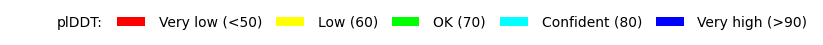

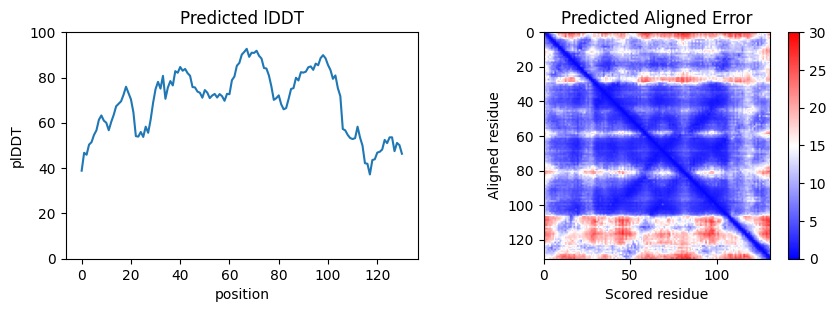

In [ ]:
#@title Display 3D structure (CA) {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 4 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()

In [ ]:
#@title Run AlphaFold (ablation_rbf_CA)
print('model loaded:',model_name)
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = len(sequences)
outs = []
positions = []
plddts = []
paes = []
LS = []

with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models * num_sequences, bar_format=TQDM_BAR_FORMAT) as pbar:
  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
  for s,ori_sequence in enumerate(sequences):
    Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
    LS.append(Ls)
    sequence = re.sub("[^A-Z]","",ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
      max_len = length + 25
      runner, params, I = setup_model(max_len)

    outs.append([])
    positions.append([])
    plddts.append([])
    paes.append([])

    r = -1
    # pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
    seq = np.pad(seq,[0,max_len-length],constant_values=-1)
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
    I.update({"seq":seq, "length":length})
    
    # for each model
    for n in range(num_models):
      # restart recycle
      I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                  'init_pair': np.zeros([1, max_len, max_len, 128]),
                  'init_pos': np.zeros([1, max_len, 37, 3])}
      for r in range(num_recycles + 1):
        O = runner(I, params[n])
        O = jax.tree_map(lambda x:np.asarray(x), O)
        I["prev"] = O["prev"]
        pbar.update(1)
      
      positions[-1].append(O["final_atom_positions"][:length])
      plddts[-1].append(O["plddt"][:length])
      paes[-1].append(O["pae"][:length,:length])
      outs[-1].append(O)
      save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
      tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
      print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

model loaded: ablation_rbf_48_020


  0%|          | 0/16 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.424	17.5	0.342
1 0	0.475	15.9	0.622
2 0	0.483	14.9	0.699
3 0	0.578	13.1	0.549
4 0	0.46	16.8	0.384
5 0	0.439	16.1	0.661
6 0	0.458	15.7	0.584
7 0	0.322	19.6	0.315


model loaded: ablation_rbf_48_020


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

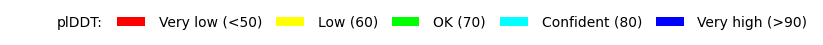

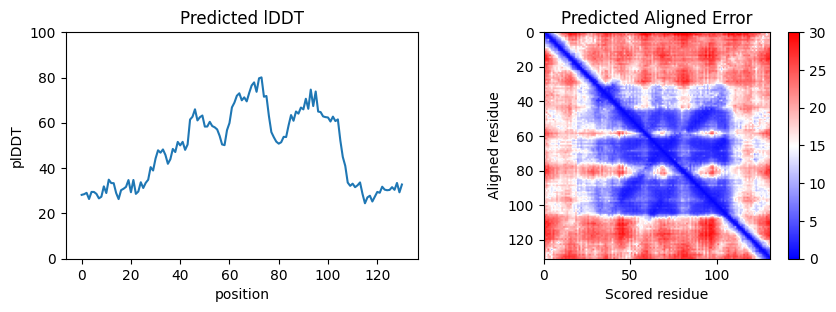

In [ ]:
#@title Display 3D structure (ablation_rbf_CA) {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 2 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()

In [ ]:
#@title Run AlphaFold (80epoch CA)
print('model loaded:',model_name)
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = len(sequences)
outs = []
positions = []
plddts = []
paes = []
LS = []

with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models * num_sequences, bar_format=TQDM_BAR_FORMAT) as pbar:
  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
  for s,ori_sequence in enumerate(sequences):
    Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
    LS.append(Ls)
    sequence = re.sub("[^A-Z]","",ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
      max_len = length + 25
      runner, params, I = setup_model(max_len)

    outs.append([])
    positions.append([])
    plddts.append([])
    paes.append([])

    r = -1
    # pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
    seq = np.pad(seq,[0,max_len-length],constant_values=-1)
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
    I.update({"seq":seq, "length":length})
    
    # for each model
    for n in range(num_models):
      # restart recycle
      I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                  'init_pair': np.zeros([1, max_len, max_len, 128]),
                  'init_pos': np.zeros([1, max_len, 37, 3])}
      for r in range(num_recycles + 1):
        O = runner(I, params[n])
        O = jax.tree_map(lambda x:np.asarray(x), O)
        I["prev"] = O["prev"]
        pbar.update(1)
      
      positions[-1].append(O["final_atom_positions"][:length])
      plddts[-1].append(O["plddt"][:length])
      paes[-1].append(O["pae"][:length,:length])
      outs[-1].append(O)
      save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
      tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
      print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

model loaded: epoch80_vanilla_CA_48_020


  0%|          | 0/16 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.6	11.5	0.734
1 0	0.334	19.5	0.301
2 0	0.607	12.0	0.68
3 0	0.523	14.4	0.628
4 0	0.395	16.9	0.511
5 0	0.546	13.1	0.529
6 0	0.566	12.7	0.681
7 0	0.559	14.2	0.663


model loaded: epoch80_vanilla_CA_48_020


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

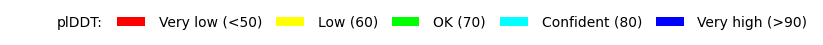

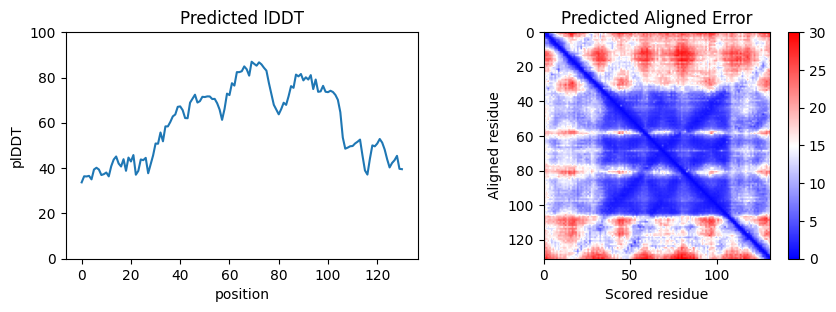

In [ ]:
#@title Display 3D structure (80epoch CA) {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 0 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()

In [ ]:
#@title Run AlphaFold (80epoch CA_SH)
print('model loaded:',model_name)
num_models = 1 #@param ["1","2","3","4","5"] {type:"raw"}
num_recycles = 1 #@param ["0","1","2","3"] {type:"raw"}
num_sequences = len(sequences)
outs = []
positions = []
plddts = []
paes = []
LS = []

with tqdm.notebook.tqdm(total=(num_recycles + 1) * num_models * num_sequences, bar_format=TQDM_BAR_FORMAT) as pbar:
  print(f"seq_num model_num avg_pLDDT avg_pAE TMscore")
  for s,ori_sequence in enumerate(sequences):
    Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
    LS.append(Ls)
    sequence = re.sub("[^A-Z]","",ori_sequence)
    length = len(sequence)

    # avoid recompiling if length within 25
    if "max_len" not in dir() or length > max_len or (max_len - length) > 25:
      max_len = length + 25
      runner, params, I = setup_model(max_len)

    outs.append([])
    positions.append([])
    plddts.append([])
    paes.append([])

    r = -1
    # pad sequence to max length
    seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
    seq = np.pad(seq,[0,max_len-length],constant_values=-1)
    I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_len), Ls, length=32)
    I.update({"seq":seq, "length":length})
    
    # for each model
    for n in range(num_models):
      # restart recycle
      I["prev"] = {'init_msa_first_row': np.zeros([1, max_len, 256]),
                  'init_pair': np.zeros([1, max_len, max_len, 128]),
                  'init_pos': np.zeros([1, max_len, 37, 3])}
      for r in range(num_recycles + 1):
        O = runner(I, params[n])
        O = jax.tree_map(lambda x:np.asarray(x), O)
        I["prev"] = O["prev"]
        pbar.update(1)
      
      positions[-1].append(O["final_atom_positions"][:length])
      plddts[-1].append(O["plddt"][:length])
      paes[-1].append(O["pae"][:length,:length])
      outs[-1].append(O)
      save_pdb(outs[-1][-1], f"out_seq_{s}_model_{n}.pdb", Ls=LS[-1])
      tmscores = mmalign(pdb_path, f"out_seq_{s}_model_{n}.pdb")
      print(f"{s} {n}\t{plddts[-1][-1].mean():.3}\t{paes[-1][-1].mean():.3}\t{tmscores[-1]:.3}")

model loaded: epoch80_CA_SH_48_020


  0%|          | 0/16 [elapsed: 00:00 remaining: ?]

seq_num model_num avg_pLDDT avg_pAE TMscore
0 0	0.647	11.7	0.769
1 0	0.37	17.7	0.324
2 0	0.535	13.1	0.586
3 0	0.689	9.31	0.851
4 0	0.487	15.0	0.609
5 0	0.333	18.6	0.294
6 0	0.522	13.9	0.782
7 0	0.564	13.0	0.772


model loaded: epoch80_CA_SH_48_020


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

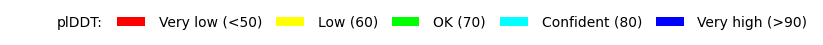

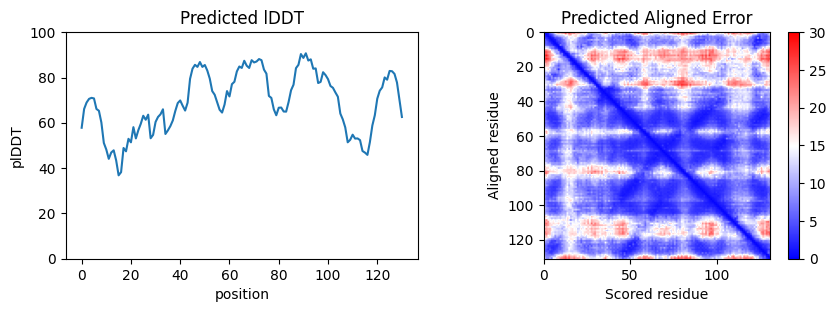

In [ ]:
#@title Display 3D structure (80epoch CA_SH) {run: "auto"}
#@markdown #### select which sequence to show (if more than one designed example)
print('model loaded:',model_name)
seq_num = 3 #@param ["0","1","2","3","4","5","6","7"] {type:"raw"}
assert seq_num < len(outs), f"ERROR: seq_num ({seq_num}) exceeds number of designed sequences ({num_sequences})"
model_num = 0 #@param ["0","1","2","3","4"] {type:"raw"}
assert model_num < len(outs[0]), f"ERROR: model_num ({num_models}) exceeds number of model params used ({num_models})"
#@markdown #### options

color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

v = cf.show_pdb(f"out_seq_{seq_num}_model_{model_num}.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=LS[seq_num])       
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()           
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[seq_num][model_num]*100, paes[seq_num][model_num], Ls=LS[seq_num]).show()

# Save

In [ ]:
ls

1O91.pdb               out_seq_1_model_0.pdb  out_seq_7_model_0.pdb
af_backprop/           out_seq_2_model_0.pdb  params/
colabfold.py           out_seq_3_model_0.pdb  __pycache__/
MMalign*               out_seq_4_model_0.pdb  results/
MMalign.cpp            out_seq_5_model_0.pdb  sample_data/
out_seq_0_model_0.pdb  out_seq_6_model_0.pdb  SO3_Invariant_ProteinMPNN/


In [ ]:
!zip -r SO3_Invariant_ProteinMPNN.zip ./SO3_Invariant_ProteinMPNN

  adding: SO3_Invariant_ProteinMPNN/ (stored 0%)
  adding: SO3_Invariant_ProteinMPNN/outputs/ (stored 0%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_2_outputs/ (stored 0%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_2_outputs/parsed_pdbs.jsonl (deflated 63%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_2_outputs/assigned_pdbs.jsonl (deflated 34%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_2_outputs/seqs/ (stored 0%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_2_outputs/seqs/3HTN.fa (deflated 51%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_2_outputs/seqs/4YOW.fa (deflated 41%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_1_outputs/ (stored 0%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_1_outputs/parsed_pdbs.jsonl (deflated 61%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_1_outputs/seqs/ (stored 0%)
  adding: SO3_Invariant_ProteinMPNN/outputs/example_1_outputs/seqs/6MRR.fa (deflated 38%)
  adding: SO3_Invariant_Pro

In [ ]:
files.download('./ProteinMPNN.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>